# Analyse data for line loop navigation coming from the homecage 

In [22]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import matplotlib
import networkx as nx
import copy as cp
import seaborn
from scipy.ndimage import gaussian_filter1d
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
cmap_ = 'RdYlGn'
cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=0.6,clip=True),cmap=cmap_)
seaborn.set(font_scale=1.5,style='ticks')

#physical positions of the pokes
poke_pos = np.array([1,-1])*np.array([ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]])

##  Main function to analyse probe trial performance

In [3]:
def get_experiment_name(line):
    return re.findall('Experiment name[\s] \: (.*)\n',line)[0]

def get_subject_name(line):
    return re.findall('Subject ID[\s]:[\s](.*)\n',line)[0]

def get_start_date(line):
    return re.findall('Start date[\s]:[\s](.*)\n',line)[0]

In [4]:
def get_probe_trial_performance_homecage(lines,fpath,MIN_REW_IN_SEQ=50):

    """ 
        Takes in lines output by pycontrol and returns a dict that contains probe trial
        performance for each transition
    
    
        Arguments:
        ===========================
        lines (list of str):             output of pycontrol
        
        Returns:
        ==========================
        all_info_dicts (list of dicts):  a list of dicts where each entry in the list
                                         is a dict containing whether probe trial\s were
                                         correct for each transition. If more than 1 graph
                                         was explored in a given session, then the performance
                                         then this list will have more than 1 dict in it. Other
                                         wise it will only have one
        
        
    """
    times = []
    probe_perf = []
    probe_target = []
    probe_from = []
    probe_to = []
    probe_transition = []
    target_hist = []; probe_hist = []; poked_hist = []; dir_hist = []; seq_hist = []

    task_nums = []
    info_dict = {'fpath': fpath}
    probe_dict = {}
    all_info_dicts = [] #this is for when there are two tasks in one session
    seq = None
    task_number = None
    graph_type = None
    n_rewards = np.nan
    full_sequences = None
    #iterate over flines
    
    probe_start = -100000
    hasrunprobe = True
    
    
    try:
        probe_dur = float(eval(re.findall('Variables(.*)',lines[-1])[0])['probe_dur'])
    except IndexError:
        probe_dur = 2000.

    try:
        n_rew_tot = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
    except IndexError:
        n_rew_tot = 0
    rew_in_seq = 0
    if n_rew_tot>10:
        for ix,l_ in enumerate(lines[:-1]):


            #find basic task metadata
            if 'Subject ID' in l_: info_dict['subject'] = get_subject_name(l_)
            if 'Experiment name' in l_: info_dict['exp_name'] = get_experiment_name(l_)
            if 'Start date' in l_: info_dict['date'] = get_start_date(l_)

                

            if 'task_number' in l_:

                #if there is already one task then store the info for the
                #'completed' task here and perform some cleanup
                if len(task_nums)>0:
                    info_dict['seq'] = seq
                    info_dict['task_nr'] = task_number
                    info_dict['probe_dict'] = probe_dict.copy()
                    info_dict['len_seq'] = None if seq is None else len(seq)
                    info_dict['graph_type'] = graph_type
                    all_info_dicts.append(info_dict.copy())
                    info_dict = info_dict.copy()
                    del info_dict['probe_dict']
                    probe_dict = {}
                task_number = int(re.findall('task_number([0-9])',l_)[0])
                task_nums.append(task_number)

            #store the sequence that was explored
            if 'seq' in l_:
                seq = eval(re.findall('seq:(\[.*\])', l_)[0])

            if 'graph_type' in l_:
                graph_type = re.findall('graph_type:(.*)\n',l_)[0]
            #process the print-lines that describe the subjects behaviour
            
            
            if rew_in_seq>MIN_REW_IN_SEQ:
                if 'probe_start' in l_:
                    probe_start = float(re.findall('P ([0-9]*)',l_)[0])
                    hasrunprobe = False


            
            if 'TARGET:' in l_:  
                t_ = re.findall('P ([0-9]*) R',l_)[0]
                times.append(float(t_))
                probe = eval(re.findall('PROBE: (False|True)',l_)[0])
                target = int(re.findall('TARGET: ([0-9]*)',l_)[0])
                poked = int(re.findall('POKED: ([0-9]*)',l_)[0])
                direction = int(re.findall('DIR: (.*)',l_)[0])
                seq_ix = int(re.findall('SEQ_IX: ([0-9]*)',l_)[0])
                try:
                    rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l_)[0])
                except IndexError:
                    rew_in_seq = 99
                    
                if seq_hist:
                    if probe:  #if it is flagged as a probe trial
                        if not hasrunprobe:   #and this probe trial has not been counted
                            if rew_in_seq>MIN_REW_IN_SEQ:
                                
                                prev_target = None
                                pt_ctr = 1
                                while prev_target is None:
                                    if target_hist[-pt_ctr]!=target:
                                        prev_target = target_hist[-pt_ctr]
                                    pt_ctr+=1
                                    

                                if ((times[-1]-probe_start)<probe_dur):
                                    if poked==prev_target:
                                        pass
                                    else:
                                        hasrunprobe = True
                                        correct_poke = poked==target
                                        probe_perf.append(correct_poke)
                                        probe_to.append(poked)
                                        probe_target.append(target)
                                        probe_from.append(prev_target)
                                        transition = str(prev_target) + '_' + str(target)
                                        probe_transition.append(transition)
                                        

                                        if transition in probe_dict.keys():
                                            probe_dict[transition].append(correct_poke)
                                        else:
                                            probe_dict[transition] = [correct_poke]
                                else:
                                    #pass
                                    hasrunprobe = True
                                    correct_poke = False
                                    probe_perf.append(correct_poke)
                                    transition = str(prev_target) + '_' + str(target)

                                    if transition in probe_dict.keys():
                                        probe_dict[transition].append(correct_poke)
                                    else:
                                        probe_dict[transition] = [correct_poke]


                target_hist.append(target); probe_hist.append(probe); dir_hist.append(direction);
                poked_hist.append(poked); seq_hist.append(seq_ix)
        #print(len(probe_perf))
        try:
            n_rewards = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
            full_sequences = (eval(re.findall('Variables(.*)',lines[-1])[0])['sequences'])
        except IndexError:
            n_rewards = np.nan

        info_dict['seq'] = seq; info_dict['task_nr'] = task_number; info_dict['probe_dict'] = probe_dict.copy()
        info_dict['len_seq'] = None if seq is None else len(seq)
        info_dict['n_rewards'] = n_rewards
        info_dict['graph_type'] = graph_type
        info_dict['full_sequences'] = full_sequences
        info_dict['probe_target'] = probe_target
        info_dict['probe_from'] = probe_from
        info_dict['probe_to'] = probe_to
        info_dict['probe_transition'] = probe_transition
        
        all_info_dicts.append(info_dict)
    return all_info_dicts

In [5]:
def build_follow_the_light_probe_df(subject_folders):
    """
    Here we loop through the subject folders and get a list of all sessions
    that is annotated with some metadata
    
    Arguments:
    =========================================
    
    subject_folders (list): list of folders where each folder contains the
                            data files for one subject
                            
    
    """
    df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seq', 'task_nr', 'probe_dict', 'len_seq','n_rewards','graph_type','sess_dur','full_sequence','fpath'])
    for ROOT in subject_folders:
        #print(ROOT)
        fs = [i for i in os.listdir(ROOT) if '_taskFile' not in i]
        probe_dict = {}
        for f_ in fs:
            if 'follow_the_light_2_graphs' in f_:
                #print(f_)
                fpath = os.path.join(ROOT,f_)
                with open(fpath,'r') as f:
                    lines = f.readlines()

                all_info_dict = get_probe_trial_performance_homecage(lines,fpath=fpath)
                #print(probe_dict)
                for i in all_info_dict:
                    df = df.append(i,ignore_index=True)
    return df, lines

In [6]:
# def merge_probe_trial_dicts(x,only_last=None):
#     """ 
#     Function passed as argument to result of pandas groupby in
#     order to merge the dicts by subject and task
    
#     Arguments:
#     =========================
#     x: what is passed by agg
    
#     only_last (int): only look at the last n probe trials for each transition
#     """
#     out = {}
#     for d in x.dropna():
#         for k,v in d.items():
#             if k not in out.keys():
#                 out[k] = v.copy()
#             else:
#                 out[k].extend(v)
                
#     if only_last:
#         for k,v in out.items():
#             out[k] = v[-only_last:]
#     return out


In [7]:
# def make_plot(res_dict,mx=1,color='mean'):
#     #plt.figure(figsize=(12,4))


# #    mx = 1
#     if color=='pval': cmap_ = 'RdYlGn_r'
#     else: cmap_ = 'RdYlGn'
#     cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

#     G0 = nx.DiGraph()
#     G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
#     nx.draw(G0,pos=poke_pos,alpha=.2,node_color='.3')


#     G = nx.DiGraph()
#     for k,v in res_dict.items():
#         if color=='pval':
#             c = stt.binom_test(np.sum(v),len(v),p=1/8.,alternative='greater')
#         else:
#             c= np.mean(v)
#         G.add_edge(int(k[0]),int(k[-1]),color=cmap.to_rgba(c))

#     colors = nx.get_edge_attributes(G,'color')

#     nx.draw(G,
#             pos=poke_pos,edge_color=np.array(list(colors.values())),
#             node_color='.3',
#             node_size=512,
#             connectionstyle="arc3,rad=-0.1",
#             width=3
#     )
#     #plt.colorbar()

In [8]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [9]:
def make_josh_plot(map_df,column,mx=1,color='mean',less_than_q=0):
    #plt.figure(figsize=(12,4))
    transition_test = column
    
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    #Fills graph
    G = nx.DiGraph()
    for row in map_df.index:
        c = (map_df.at[row,transition_test])/max(map_df[transition_test])
        if c < less_than_q: G.add_edge(int(transition_test[0]),int(row),color='w')
        else: G.add_edge(int(transition_test[0]),int(row),color=cmap.to_rgba(c))
    colors = nx.get_edge_attributes(G,'color')

    #makes graph correct shape
    nx.draw(G,
            pos=poke_pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=512,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )

In [10]:
figure_path = '/Users/joshuakeeling/Documents/Python/Project/Figures'

def save_figure(name, base_path=figure_path):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'), 
                bbox_inches='tight', transparent=True)


# Run analysis

In [11]:
df = pd.DataFrame(columns=['subject','time','seq','graph_type','two_tasks','nRews','probe_dict','probe_from'
                          'probe_target','probe_to'])

In [12]:
all_mice_csv = pd.read_csv('/Users/joshuakeeling/Dropbox/pyhomecage/mice/mice.csv')


In [13]:
all_data = []
for ix,row in all_mice_csv.iterrows():
    if 'ec_lineloop' in row['Experiment'] and not pd.isnull(row['set_variables']):
        try:
            tmp = [row['Mouse_ID'],
                   eval(eval(row['set_variables'])['v.len_seqs'])]
            all_data.append(tmp)
        except:
            print("error in:",row['Mouse_ID'])
            pass
        

error in: C00499495_2


In [14]:
all_data

[['C00494062_1', [9, 9]],
 ['C00494062_2', [9, 9]],
 ['C00494062_3', [9, 9]],
 ['C00494062_4', [9, 9]],
 ['C00494062_5', [9, 9]],
 ['C00499495_1', [9, 9]],
 ['C00499495_3', [9, 9]],
 ['C00499495_4', [9, 9]],
 ['C00499495_5', [9, 9]],
 ['C00499495_6', [9, 9]]]

In [15]:
np.mean([i[1] for i in all_data],axis=0)

array([9., 9.])

In [16]:
experiment_folders = ['/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_1/',
                     '/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_2/']

subject_folders = []
for ef in experiment_folders:
    sf1 = os.listdir(ef)
    
    for sf_ in sf1:
        sf = os.path.join(ef,sf_)
        #print(sf)
        #if sf=='/Users/yves/Downloads/ec_lineloop_2/.DS_Store':
        #|print('.DS' in sf)
        if not ('.DS' in sf):
            fold2 = [i for i in os.listdir(sf) if '.DS' not in i][0]
            subject_folders.append(os.path.join(sf,fold2))


## Slow

In [17]:
df,lines = build_follow_the_light_probe_df(subject_folders)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['n_rewards']>1]
df = df.sort_values('date')
if 'old_df' not in locals():
    old_df = cp.deepcopy(df)
    
df.to_csv('tmp.pd')

## Interesting stuff begins

In [18]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [19]:
#look at filtered df

subject_name = 'C00499495_1'
task_nr=1
min_rew=50
r_len_seq=9
n_days=150
show_raw=False

df[(df['n_rewards']>min_rew)\
        & (df['subject']==subject_name)\
        #& (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})\
        & (df['date']>(datetime.now()-timedelta(days=n_days)))].sort_values('date')

,subject,exp_name,date,seq,task_nr,probe_dict,len_seq,n_rewards,graph_type,sess_dur,full_sequence,fpath,full_sequences,probe_from,probe_target,probe_to,probe_transition
8298,C00499495_1,ec_lineloop_2,2021-06-10 17:29:39,"[8, 4, 2, 5, 7, 0, 6, 1, 3]",0,"{'1_3': [False, False], '4_2': [False, False, ...",9,70.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[1, 4, 4, 8, 6, 5, 4, 3, 0, 4, 5, 4, 5, 1, 4, ...","[3, 2, 2, 3, 0, 2, 8, 1, 7, 8, 2, 8, 7, 3, 2, ...","[0, 8, 8, 6, 8, 2, 8, 6, 7, 8, 2, 8, 7, 4, 8, ...","[1_3, 4_2, 4_2, 8_3, 6_0, 5_2, 4_8, 3_1, 0_7, ..."
8047,C00499495_1,ec_lineloop_2,2021-06-10 23:56:19,"[8, 4, 2, 5, 7, 0, 6, 1, 3]",0,"{'7_0': [True], '8_3': [False, False], '3_1': ...",9,57.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[7, 8, 3, 7, 0, 2, 0, 2, 8, 2]","[0, 3, 1, 5, 7, 4, 7, 4, 3, 4]","[0, 4, 6, 8, 8, 4, 7, 7, 4, 4]","[7_0, 8_3, 3_1, 7_5, 0_7, 2_4, 0_7, 2_4, 8_3, ..."
8331,C00499495_1,ec_lineloop_2,2021-06-11 00:34:05,"[8, 4, 2, 5, 7, 0, 6, 1, 3]",0,"{'6_0': [False], '0_7': [True, True, True, Tru...",9,57.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[6, 0, 2, 0, 8, 0, 8, 0, 5, 1, 4, 0, 7, 2]","[0, 7, 4, 7, 3, 7, 3, 7, 2, 6, 8, 7, 5, 4]","[1, 7, 4, 7, 4, 7, 4, 7, 2, 6, 8, 7, 4, 7]","[6_0, 0_7, 2_4, 0_7, 8_3, 0_7, 8_3, 0_7, 5_2, ..."
8246,C00499495_1,ec_lineloop_2,2021-06-11 01:09:39,"[8, 4, 2, 5, 7, 0, 6, 1, 3]",0,"{'0_7': [True, False], '8_4': [True, False], '...",9,74.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[0, 8, 7, 3, 0, 4, 3, 1, 7, 2, 0, 1, 3, 2, 1, ...","[7, 4, 5, 1, 7, 8, 1, 6, 5, 4, 6, 3, 8, 5, 3, ...","[7, 4, 5, 6, 2, 8, 1, 6, 4, 4, 6, 3, 1, 7, 4, ...","[0_7, 8_4, 7_5, 3_1, 0_7, 4_8, 3_1, 1_6, 7_5, ..."
8412,C00499495_1,ec_lineloop_2,2021-06-14 22:16:41,"[8, 4, 2, 5, 7, 0, 6, 1, 3]",0,"{'7_5': [True, True], '5_2': [True], '4_8': [T...",9,52.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[7, 5, 4, 3, 7, 2, 1, 2, 1, 3, 2, 8, 6]","[5, 2, 8, 1, 5, 4, 3, 5, 3, 8, 5, 3, 0]","[5, 2, 8, 6, 5, 4, 6, 4, 8, 1, 7, 2, 3]","[7_5, 5_2, 4_8, 3_1, 7_5, 2_4, 1_3, 2_5, 1_3, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8167,C00499495_1,ec_lineloop_2,2021-07-08 04:01:35,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",1,"{'2_8': [False, True, True, True], '7_5': [Tru...",9,66.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[2, 7, 3, 0, 2, 8, 4, 5, 1, 0, 8, 7, 1, 7, 5, ...","[8, 5, 6, 2, 8, 4, 7, 1, 3, 2, 4, 5, 5, 4, 7, ...","[7, 5, 6, 2, 8, 4, 7, 2, 6, 7, 4, 5, 3, 4, 7, ...","[2_8, 7_5, 3_6, 0_2, 2_8, 8_4, 4_7, 5_1, 1_3, ..."
8520,C00499495_1,ec_lineloop_2,2021-07-08 05:35:38,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",1,"{'8_2': [False, False, False, True, False, Tru...",9,73.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[8, 6, 1, 0, 2, 8, 4, 7, 5, 6, 4, 8, 2, 1, 8, ...","[2, 3, 5, 2, 8, 4, 7, 5, 1, 0, 7, 2, 0, 5, 2, ...","[4, 3, 5, 2, 4, 4, 7, 5, 1, 0, 7, 7, 4, 2, 4, ...","[8_2, 6_3, 1_5, 0_2, 2_8, 8_4, 4_7, 7_5, 5_1, ..."
8304,C00499495_1,ec_lineloop_2,2021-07-08 20:05:51,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",1,"{'8_4': [True, True, True], '6_0': [False, Fal...",9,63.0,loop,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[8, 4, 2, 5, 7, 0, 6, 1, 3], [1, 3, 6, 0, 2, ...","[8, 6, 2, 8, 5, 2, 6, 3, 0, 2, 8, 7, 4, 5, 1, ...","[4, 0, 8, 4, 1, 8, 3, 1, 2, 8, 4, 5, 8, 1, 3, ...","[4, 4, 8, 4, 0, 8, 1, 1, 2, 8, 4, 5, 8, 1, 3, ...","[8_4, 6_0, 2_8, 8_4, 5_1, 2_8, 6_3, 3_1, 0_2, ..."
8435,C00499495_1,ec_lineloop_2,2021-07-08 22:19:08,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",1,"{'4_7': [False], '7_5': [False, True, True], '...",9,64.0,loop,

In [20]:

df2 = df[(df['n_rewards']>min_rew)\
 #       & (df['subject']==subject_name)\
#         & (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})].sort_values('date')

np.nanmean(np.hstack(df2["probe_target"])==np.hstack(df2["probe_to"]))

0.7028084010622032

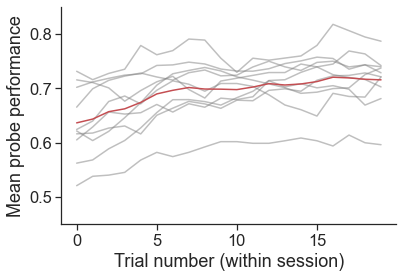

In [23]:
y = []
all_y=[]
for subject in df['subject'].unique():
    y=[]
    for index in (df2[df2['subject']==subject].index):
        x=[]
        x=1*([np.hstack(df2["probe_target"][index])==np.hstack(df2["probe_to"][index])][0])
        #plt.plot(moving_average(x,6))
        y.append(moving_average(x,6))

    power_arrs = y
    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((len(power_arrs),maxlen))
    for i, arr in enumerate(power_arrs):
        arr = np.append(arr,['NaN']*(maxlen - len(arr)))
        tomean[i] = arr

    ax = sns.lineplot(data=np.nanmean(tomean[:,:20],axis=0),color='grey',alpha=0.5)
    
    all_y.append(np.nanmean(tomean[:,:20],axis=0))

ax = sns.lineplot(data=np.mean(all_y,axis=0),alpha=1,color='r')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Trial number (within session)')
ax.set_ylabel('Mean probe performance')
ax.set_ylim(0.45,0.85)
save_figure('Perf across sessions')

In [24]:
np.nanmean(np.vstack(all_y)[:,:6],axis=1)

array([0.74186757, 0.64539792, 0.6011403 , 0.72096394, 0.54932852,
       0.66574112, 0.70858083, 0.64490614, 0.7020202 , 0.62650379])

!!!!significant!!!!


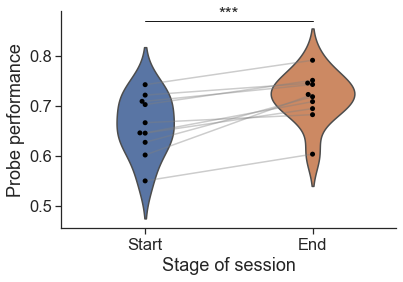

In [25]:
labels = ["Start","End"]

a = np.nanmean(np.vstack(all_y)[:,:6],axis=1)
b = np.nanmean(np.vstack(all_y)[:,-6:],axis=1)

if stt.ttest_rel(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")

x = a,b 
#ax = sns.boxplot(data = x,width=0.25)
ax = sns.swarmplot(data = x, color = 'black',alpha=1)
ax = sns.violinplot(data = x, inner = None , width = 0.5)
for i in range(len(a)):
    plt.plot( [0,1], [a[i], b[i]], c='grey',alpha=0.4)
ax.set_xticklabels(labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Stage of session')
ax.set_ylabel('Probe performance')

save_figure('Comp btwn start and end of session')

In [26]:
#is it ok to do this?
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                  


def show_mistakes(subject_name,task_nr,min_rew,r_len_seq,less_than_p=0,
                  reorder=True,n_days=15,show_raw=False, get_stats = True,sessions_arr=[0,-1]):
    df1 = df[(df['n_rewards']>min_rew)\
        & (df['subject']==subject_name)\
        & (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})\
        & (df['date']>(datetime.now()-timedelta(days=n_days)))].sort_values(['date'])
    if df1.empty is False:
        sequence = df1['seq'].values[0]
        graph_t = df1['graph_type'].values[0]

        transitions = get_all_transition(sequence,graph_t)
        map_df = pd.DataFrame(0, index=np.arange(r_len_seq),columns=transitions)

        if reorder is True:
            map_df = map_df.reindex(sorted(map_df.columns), axis=1)
        
        for session in df1.index[sessions_arr[0]:sessions_arr[1]]:
            for transition in map_df.columns:
                trans_ind = np.where(np.asarray(df.at[session,'probe_transition'])==transition)[0] #get indices of each time it was meant to do this transitiion 
                where_to = np.asarray(df.at[session,'probe_to'])[trans_ind] #get where it went for each time it was meant to do this transition

                for where_to_ind in where_to:
                    map_df.loc[[where_to_ind],[transition]] = map_df.loc[[where_to_ind],[transition]]+1

        if get_stats is True:
            mist_counter = 0
            direction_m = 0
            structure_m = 0
            recent_add_m = 0
            to_8=0
            for transition_test in map_df.columns:
                transitions1 = transitions
                #get other set of transitions by changing task nr
                transitions2 = get_all_transition(df[(df['n_rewards']>min_rew)\
                                    & (df['subject']==subject_name)\
                                    & (df['task_nr']==abs(task_nr-1))\
                                    & (df['len_seq']==r_len_seq)\
                                    & (df['probe_dict']!={})\
                                    & (df['date']>(datetime.now()-timedelta(days=n_days)))]['seq'].values[0],
                                    df[(df['n_rewards']>min_rew)\
                                    & (df['subject']==subject_name)\
                                    & (df['task_nr']==abs(task_nr-1))\
                                    & (df['len_seq']==r_len_seq)\
                                    & (df['probe_dict']!={})\
                                    & (df['date']>(datetime.now()-timedelta(days=n_days)))]['graph_type'].values[0])
                #get transitions of 1 shorter seq
                transitions3 = get_all_transition(df[(df['n_rewards']>min_rew)\
                                    & (df['subject']==subject_name)\
                                    & (df['task_nr']==task_nr)\
                                    & (df['len_seq']==r_len_seq-2)\
                                    & (df['probe_dict']!={})]['seq'].values[0],
                                    df[(df['n_rewards']>min_rew)\
                                    & (df['subject']==subject_name)\
                                    & (df['task_nr']==task_nr)\
                                    & (df['len_seq']==r_len_seq-2)\
                                    & (df['probe_dict']!={})]['graph_type'].values[0])

                for row in map_df.index:
                    c = (map_df.at[row,transition_test])/max(map_df[transition_test])
                    if c >= less_than_p:
                        if row != int(transition_test[2]):
                            mist_counter +=1
                            transition_wrong = str(transition_test[0])+'_'+str(row)
                            if transition_wrong in transitions1:
                                direction_m += 1
                                print(transition_test,transition_wrong,c,'direction')
                            if transition_wrong in transitions2:
                                structure_m += 1
                                print(transition_test,transition_wrong,c,'structure')
                            if transition_test not in transitions3:
                                recent_add_m += 1
                                print(transition_test,transition_wrong,c,'recent_add')
                            if transition_wrong == str(transition_test[0])+'_'+str('8'):
                                to_8+=1
            print('Direction mistakes:',direction_m,
                  '\nStructure mistakes:',structure_m,
                 '\nRecently added mistakes:', recent_add_m,
                 '\nShorter sequence:', transitions3)
        plt.figure(figsize=(32,8))
        ctr = 0
        subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

        for column in map_df.columns:
            plt.subplot(2,10,subplot_pos[ctr])
            plt.title(column+' : '+str(sum(map_df[column])))
            make_josh_plot(map_df,column,less_than_q=less_than_p)

            ctr+=1

        print(graph_t,':',sequence,
              '\nnumber of sessions: ' + str(len(df1)),
             '\n'+subject)
        plt.show()
        return direction_m, structure_m, recent_add_m, mist_counter,to_8
    
    else:
        print("\n\n\nSubject:"+graph_t+' '+subject+": DF IS EMPTY\n\n\n")
    
#     if show_raw is True:
#         return map_df

In [27]:
subject_name='C00499495_1'
task_nr=0
min_rew=10
r_len_seq=9
n_days=70

f1 = df[(df['n_rewards']>min_rew)\
        & (df['subject']==subject_name)\
        & (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})\
        & (df['date']>(datetime.now()-timedelta(days=n_days)))].sort_values(['date'])
f1.index

Int64Index([7880, 8384, 8149, 8374, 8411, 8003, 8668, 8298, 8565, 8047,
            ...
            7919, 7944, 7656, 8601, 8388, 8456, 8279, 8509, 7662, 7922],
           dtype='int64', length=146)

In [28]:
df['subject'].unique()

array(['C00499495_5', 'C00499495_3', 'C00499495_1', 'C00494062_3',
       'C00494062_2', 'C00499495_6', 'C00494062_1', 'C00494062_4',
       'C00499495_4', 'C00494062_5'], dtype=object)

In [ ]:
%debug

0_2 0_4 0.8 structure
0_2 0_4 0.8 recent_add
2_0 2_4 0.5340909090909091 recent_add
2_0 2_7 0.875 direction
2_0 2_7 0.875 recent_add
5_4 5_2 1.0 structure
Direction mistakes: 1 
Structure mistakes: 2 
Recently added mistakes: 3 
Shorter sequence: ['3_6', '6_3', '6_1', '1_6', '1_8', '8_1', '8_4', '4_8', '4_5', '5_4', '5_7', '7_5']
line : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 146 
C00499495_5


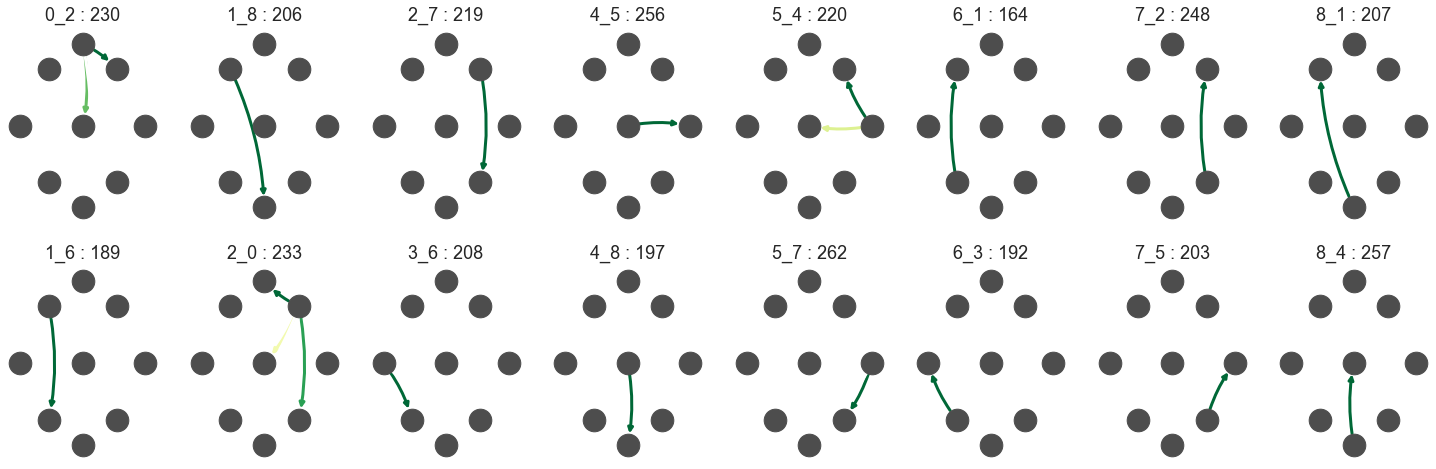

0_7 0_4 1.0 direction
1_3 1_6 0.6666666666666666 structure
1_3 1_6 0.6666666666666666 recent_add
1_3 1_8 1.0 direction
1_3 1_8 1.0 structure
1_3 1_8 1.0 recent_add
2_6 2_0 1.0 structure
3_1 3_6 1.0 structure
3_1 3_6 1.0 recent_add
4_0 4_8 0.5625 structure
5_4 5_2 1.0 direction
6_2 6_1 1.0 structure
8_1 8_4 0.5263157894736842 structure
8_1 8_4 0.5263157894736842 recent_add
8_1 8_6 1.0 direction
8_1 8_6 1.0 recent_add
8_6 8_4 1.0 structure
Direction mistakes: 4 
Structure mistakes: 8 
Recently added mistakes: 5 
Shorter sequence: ['7_0', '0_7', '0_4', '4_0', '4_5', '5_4', '5_2', '2_5', '2_6', '6_2', '6_8', '8_6']
line : [7, 0, 4, 5, 2, 6, 8, 1, 3] 
number of sessions: 31 
C00499495_5


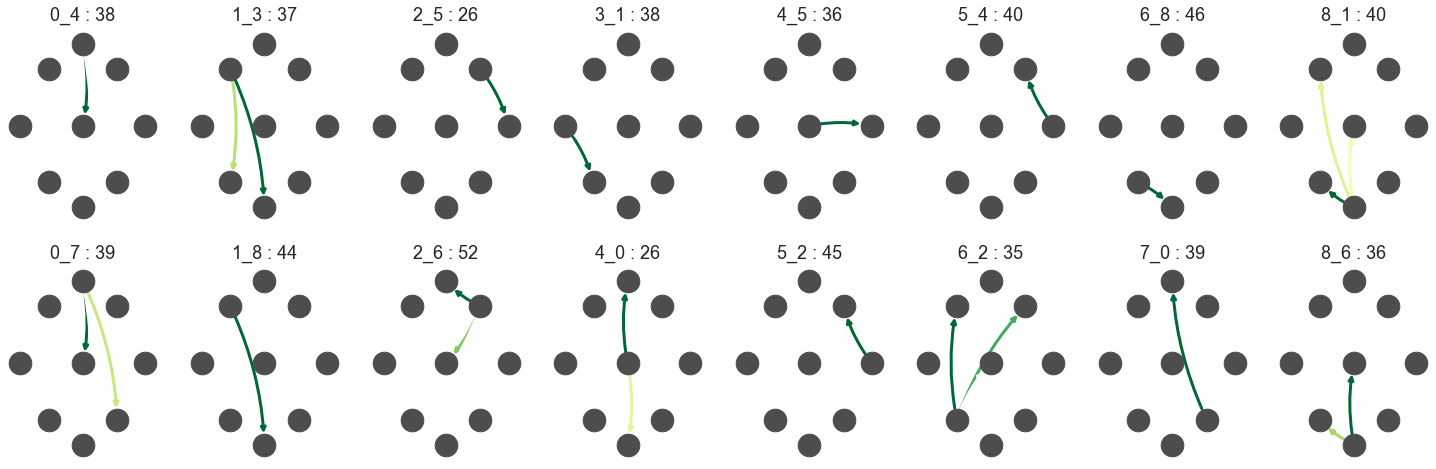

0_2 0_4 1.0 structure
0_2 0_4 1.0 recent_add
1_8 1_6 0.5416666666666666 direction
2_0 2_7 0.9130434782608695 direction
2_0 2_7 0.9130434782608695 recent_add
5_4 5_2 0.7433628318584071 structure
8_1 8_6 0.7722772277227723 structure
Direction mistakes: 2 
Structure mistakes: 3 
Recently added mistakes: 2 
Shorter sequence: ['3_6', '6_3', '6_1', '1_6', '1_8', '8_1', '8_4', '4_8', '4_5', '5_4', '5_7', '7_5']
line : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 145 
C00499495_3


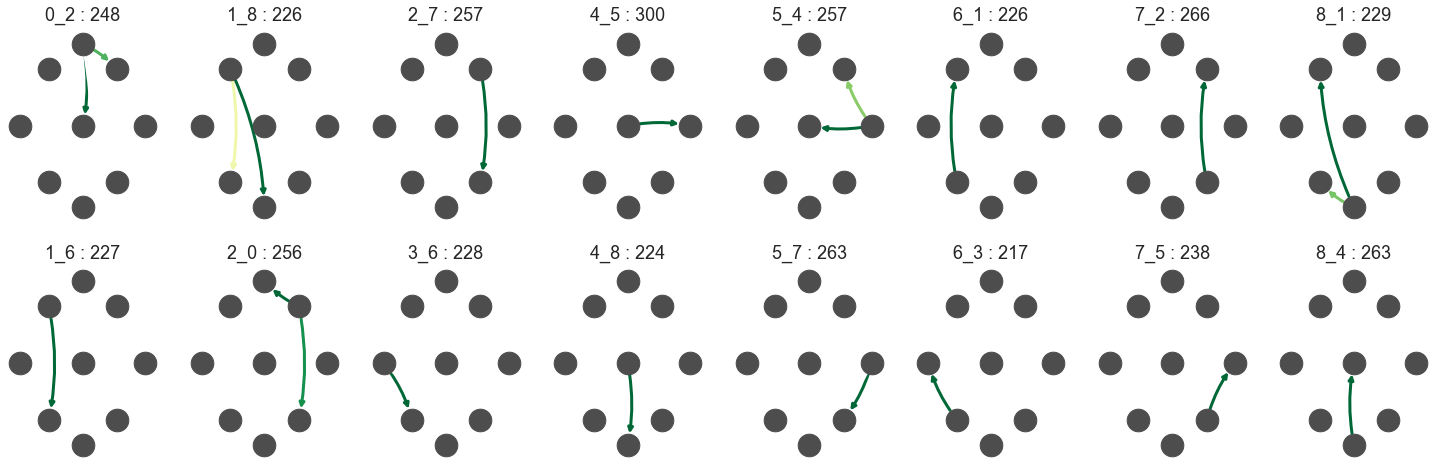

1_3 1_6 1.0 structure
1_3 1_6 1.0 recent_add
1_8 1_6 0.5714285714285714 structure
1_8 1_6 0.5714285714285714 recent_add
2_5 2_0 0.5 structure
2_5 2_7 0.75 structure
2_6 2_0 1.0 structure
3_1 3_6 1.0 structure
3_1 3_6 1.0 recent_add
3_7 3_6 1.0 structure
3_7 3_6 1.0 recent_add
4_5 4_0 0.6363636363636364 direction
5_4 5_2 0.8333333333333334 direction
5_4 5_7 1.0 structure
6_2 6_8 1.0 direction
7_0 7_2 0.7777777777777778 structure
7_3 7_5 0.6111111111111112 structure
7_3 7_5 0.6111111111111112 recent_add
7_3 7_8 1.0 recent_add
8_1 8_6 0.625 direction
8_1 8_6 0.625 recent_add
8_1 8_7 1.0 recent_add
8_6 8_4 0.5 structure
Direction mistakes: 4 
Structure mistakes: 11 
Recently added mistakes: 8 
Shorter sequence: ['7_0', '0_4', '4_5', '5_2', '2_6', '6_8', '8_7', '8_6', '6_2', '2_5', '5_4', '4_0', '0_7', '7_8']
loop : [7, 0, 4, 5, 2, 6, 8, 1, 3] 
number of sessions: 36 
C00499495_3


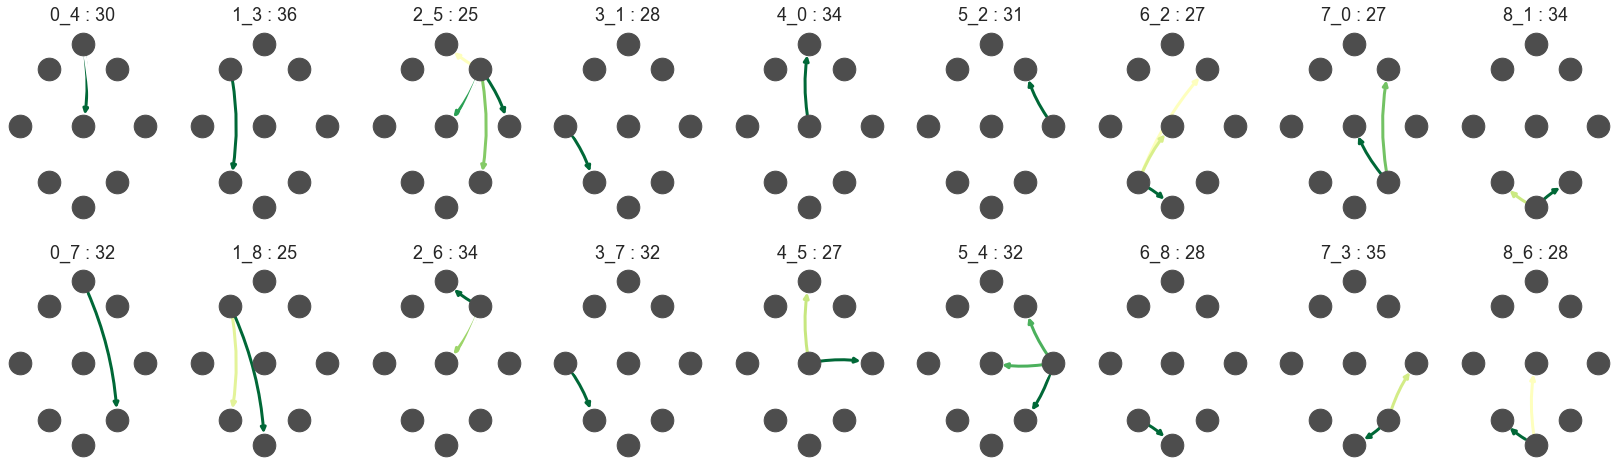

3_1 3_6 0.6666666666666666 structure
3_1 3_6 0.6666666666666666 recent_add
3_8 3_6 1.0 structure
3_8 3_6 1.0 recent_add
4_2 4_8 1.0 direction
4_2 4_8 1.0 structure
7_0 7_4 0.7391304347826086 structure
8_3 8_2 0.8888888888888888 structure
8_3 8_2 0.8888888888888888 recent_add
8_3 8_4 1.0 direction
8_3 8_4 1.0 structure
8_3 8_4 1.0 recent_add
Direction mistakes: 2 
Structure mistakes: 6 
Recently added mistakes: 4 
Shorter sequence: ['8_4', '4_2', '2_5', '5_7', '7_0', '0_6', '6_8', '6_0', '0_7', '7_5', '5_2', '2_4', '4_8', '8_6']
loop : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 131 
C00499495_1


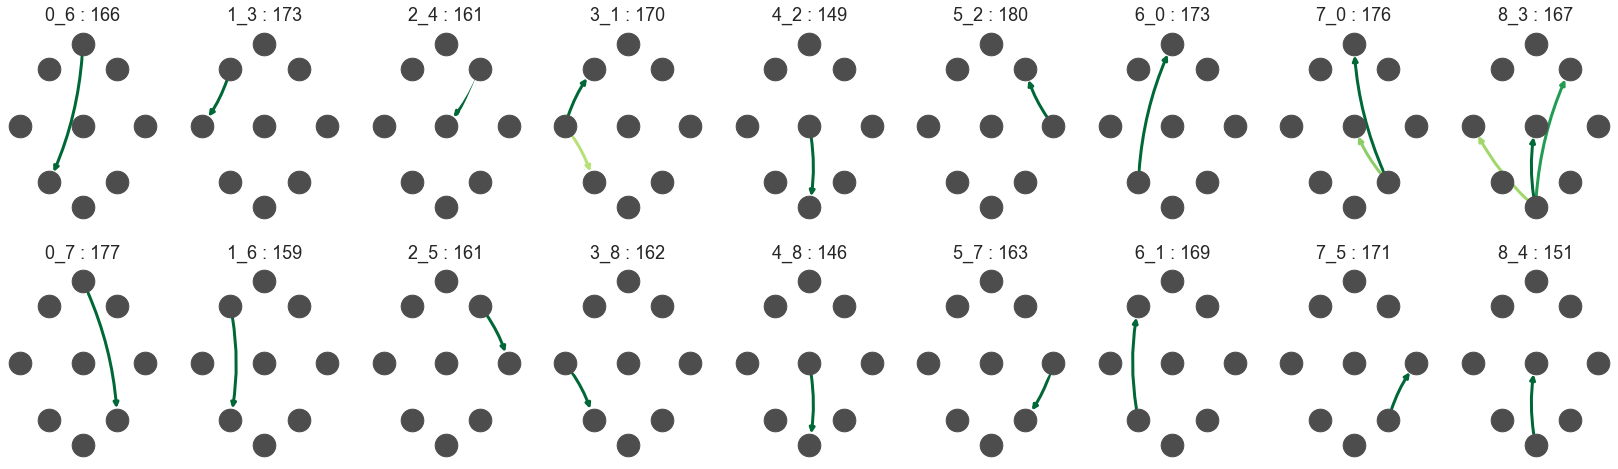

1_3 1_6 0.6285714285714286 structure
1_5 1_6 1.0 structure
1_5 1_6 1.0 recent_add
4_7 4_8 1.0 direction
4_7 4_8 1.0 structure
4_7 4_8 1.0 recent_add
5_1 5_2 1.0 structure
5_1 5_2 1.0 recent_add
5_1 5_7 0.6052631578947368 direction
5_1 5_7 0.6052631578947368 structure
5_1 5_7 0.6052631578947368 recent_add
6_0 6_1 0.5466666666666666 structure
Direction mistakes: 2 
Structure mistakes: 6 
Recently added mistakes: 4 
Shorter sequence: ['1_3', '3_6', '6_0', '0_2', '2_8', '8_4', '4_1', '4_8', '8_2', '2_0', '0_6', '6_3', '3_1', '1_4']
loop : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 115 
C00499495_1


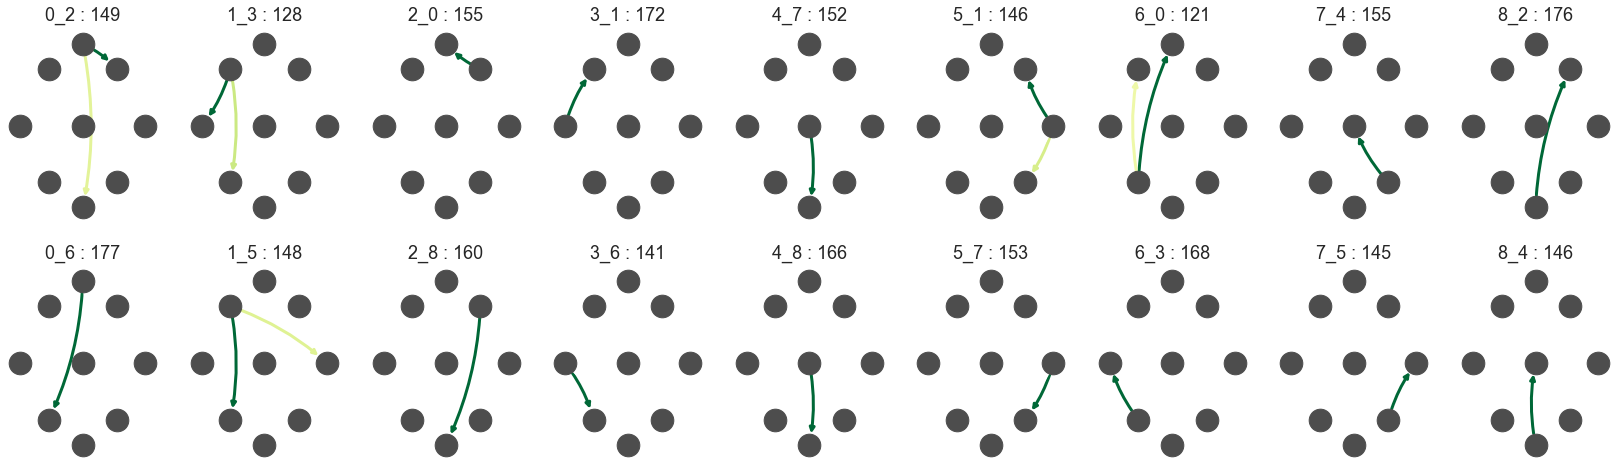

Direction mistakes: 0 
Structure mistakes: 0 
Recently added mistakes: 0 
Shorter sequence: ['8_4', '4_8', '4_2', '2_4', '2_5', '5_2', '5_7', '7_5', '7_0', '0_7', '0_6', '6_0']
line : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 58 
C00494062_3


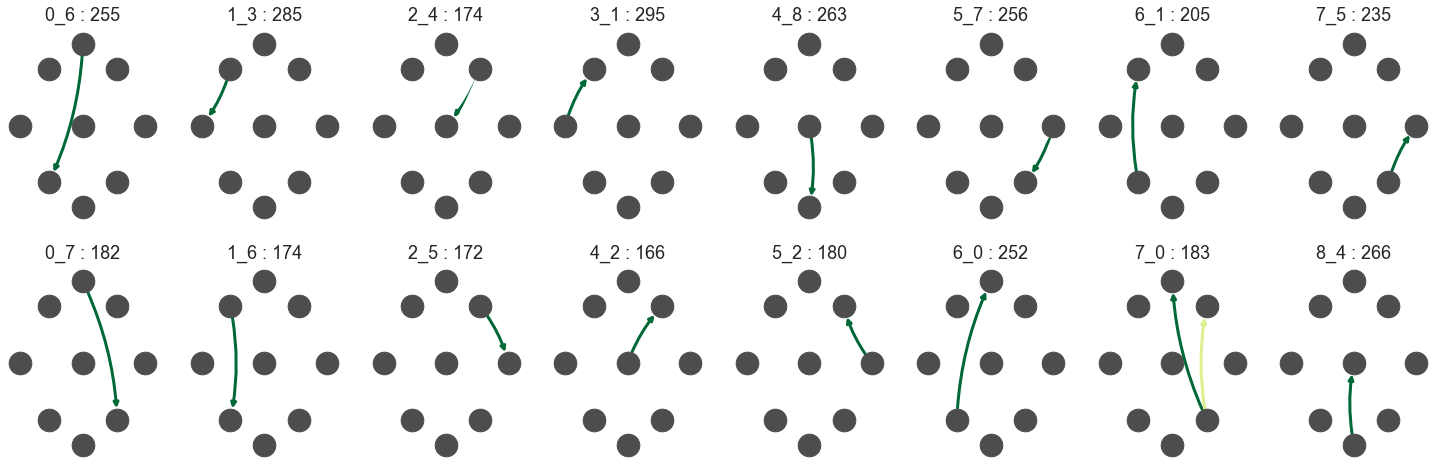

1_5 1_6 0.944 structure
1_5 1_6 0.944 recent_add
5_1 5_0 0.6078431372549019 recent_add
5_1 5_2 1.0 structure
5_1 5_2 1.0 recent_add
5_1 5_7 0.5620915032679739 direction
5_1 5_7 0.5620915032679739 structure
5_1 5_7 0.5620915032679739 recent_add
8_2 8_4 1.0 direction
8_2 8_4 1.0 structure
Direction mistakes: 2 
Structure mistakes: 4 
Recently added mistakes: 4 
Shorter sequence: ['1_3', '3_6', '6_0', '0_2', '2_8', '8_4', '4_1', '4_8', '8_2', '2_0', '0_6', '6_3', '3_1', '1_4']
loop : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 114 
C00494062_3


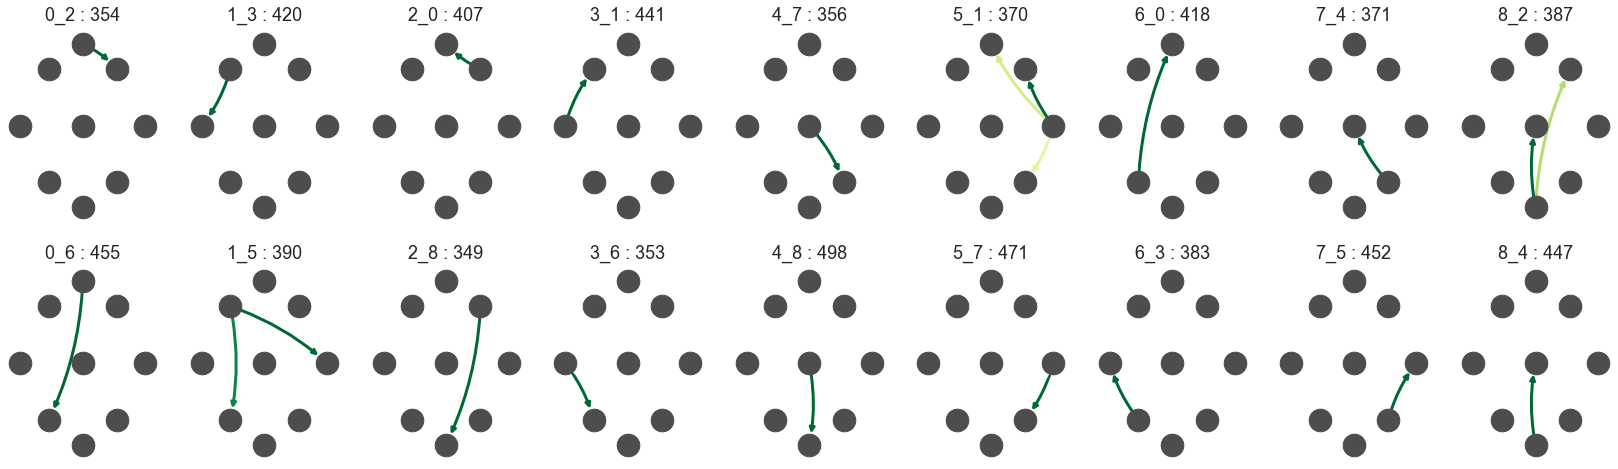

2_5 2_7 1.0 direction
2_5 2_7 1.0 recent_add
3_4 3_6 1.0 direction
3_4 3_6 1.0 structure
4_3 4_0 1.0 direction
4_3 4_0 1.0 structure
5_2 5_7 1.0 structure
5_2 5_7 1.0 recent_add
5_8 5_7 1.0 structure
5_8 5_7 1.0 recent_add
7_0 7_2 1.0 direction
8_5 8_1 0.8615384615384616 direction
8_5 8_1 0.8615384615384616 structure
8_5 8_1 0.8615384615384616 recent_add
8_5 8_2 0.6 structure
8_5 8_2 0.6 recent_add
8_5 8_4 1.0 recent_add
8_5 8_7 0.7384615384615385 recent_add
Direction mistakes: 5 
Structure mistakes: 6 
Recently added mistakes: 7 
Shorter sequence: ['8_1', '1_6', '6_3', '3_4', '4_0', '0_7', '7_8', '7_0', '0_4', '4_3', '3_6', '6_1', '1_8', '8_7']
loop : [8, 1, 6, 3, 4, 0, 7, 2, 5] 
number of sessions: 94 
C00494062_2


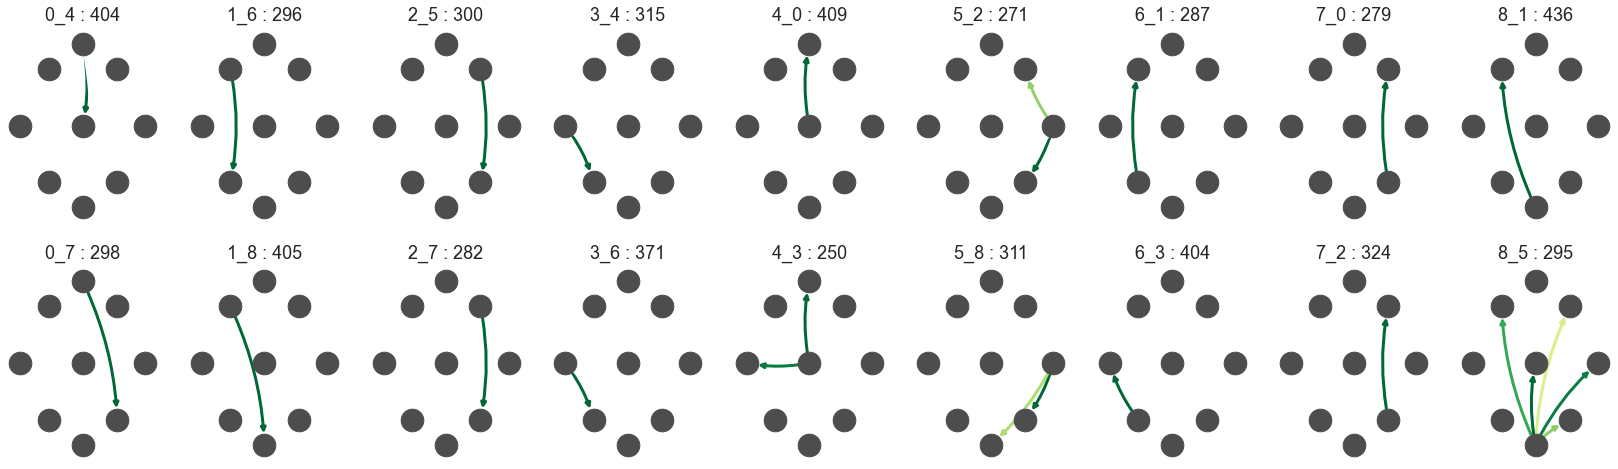

0_6 0_4 0.603448275862069 direction
0_6 0_4 0.603448275862069 structure
0_6 0_4 0.603448275862069 recent_add
2_3 2_7 1.0 structure
2_3 2_7 1.0 recent_add
2_8 2_7 0.5766871165644172 structure
3_2 3_6 1.0 direction
3_2 3_6 1.0 structure
3_2 3_6 1.0 recent_add
4_5 4_0 1.0 direction
4_5 4_0 1.0 structure
5_4 5_2 1.0 structure
5_4 5_7 0.9487179487179487 direction
6_0 6_1 1.0 structure
6_0 6_1 1.0 recent_add
7_1 7_0 0.7281553398058253 structure
7_1 7_2 1.0 structure
7_1 7_5 0.8640776699029126 direction
Direction mistakes: 5 
Structure mistakes: 9 
Recently added mistakes: 4 
Shorter sequence: ['0_4', '4_5', '5_7', '7_1', '1_8', '8_2', '2_0', '2_8', '8_1', '1_7', '7_5', '5_4', '4_0', '0_2']
loop : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 103 
C00494062_2


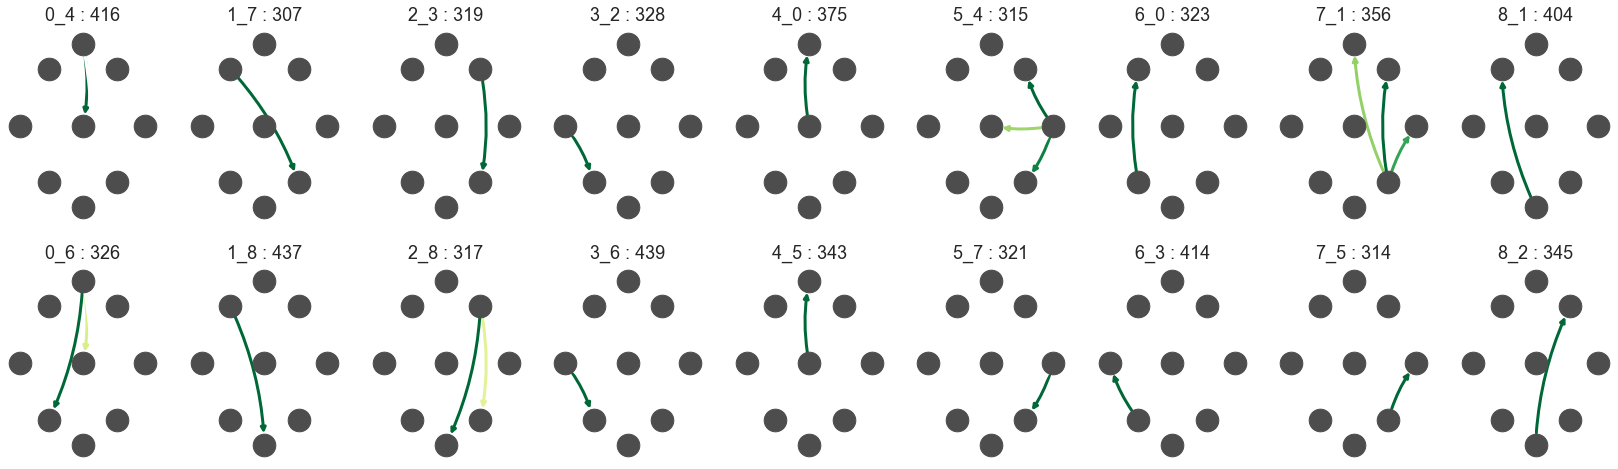

0_2 0_4 0.75 structure
0_2 0_4 0.75 recent_add
0_2 0_7 0.8333333333333334 structure
0_2 0_7 0.8333333333333334 recent_add
0_3 0_4 1.0 structure
0_3 0_4 1.0 recent_add
3_0 3_1 1.0 structure
3_0 3_1 1.0 recent_add
3_0 3_6 0.5211267605633803 direction
3_0 3_6 0.5211267605633803 recent_add
5_4 5_2 1.0 structure
Direction mistakes: 1 
Structure mistakes: 5 
Recently added mistakes: 5 
Shorter sequence: ['3_6', '6_1', '1_8', '8_4', '4_5', '5_7', '7_3', '7_5', '5_4', '4_8', '8_1', '1_6', '6_3', '3_7']
loop : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 137 
C00499495_6


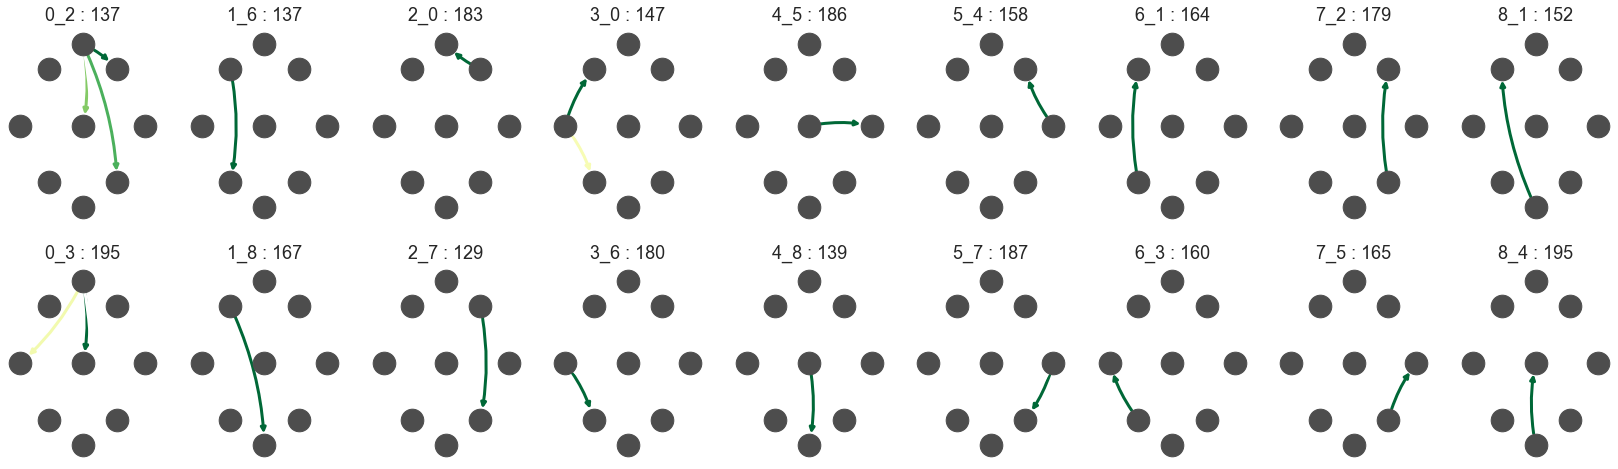

0_7 0_4 0.7906976744186046 direction
1_3 1_6 1.0 structure
1_3 1_6 1.0 recent_add
2_5 2_0 0.6363636363636364 structure
2_5 2_7 1.0 structure
2_6 2_0 0.7142857142857143 structure
3_1 3_6 1.0 structure
3_1 3_6 1.0 recent_add
3_7 3_1 0.8636363636363636 direction
3_7 3_1 0.8636363636363636 recent_add
3_7 3_6 1.0 structure
3_7 3_6 1.0 recent_add
4_0 4_8 0.9565217391304348 structure
4_5 4_0 0.7272727272727273 direction
5_4 5_2 1.0 direction
5_4 5_7 0.5454545454545454 structure
6_2 6_1 1.0 structure
7_0 7_2 0.9333333333333333 structure
7_0 7_5 1.0 structure
7_3 7_4 0.5652173913043478 recent_add
7_3 7_5 1.0 structure
7_3 7_5 1.0 recent_add
7_3 7_8 0.6086956521739131 recent_add
8_1 8_4 1.0 structure
8_1 8_4 1.0 recent_add
8_1 8_6 0.9285714285714286 direction
8_1 8_6 0.9285714285714286 recent_add
8_6 8_4 1.0 structure
Direction mistakes: 5 
Structure mistakes: 14 
Recently added mistakes: 9 
Shorter sequence: ['7_0', '0_4', '4_5', '5_2', '2_6', '6_8', '8_7', '8_6', '6_2', '2_5', '5_4', '4_0', '0

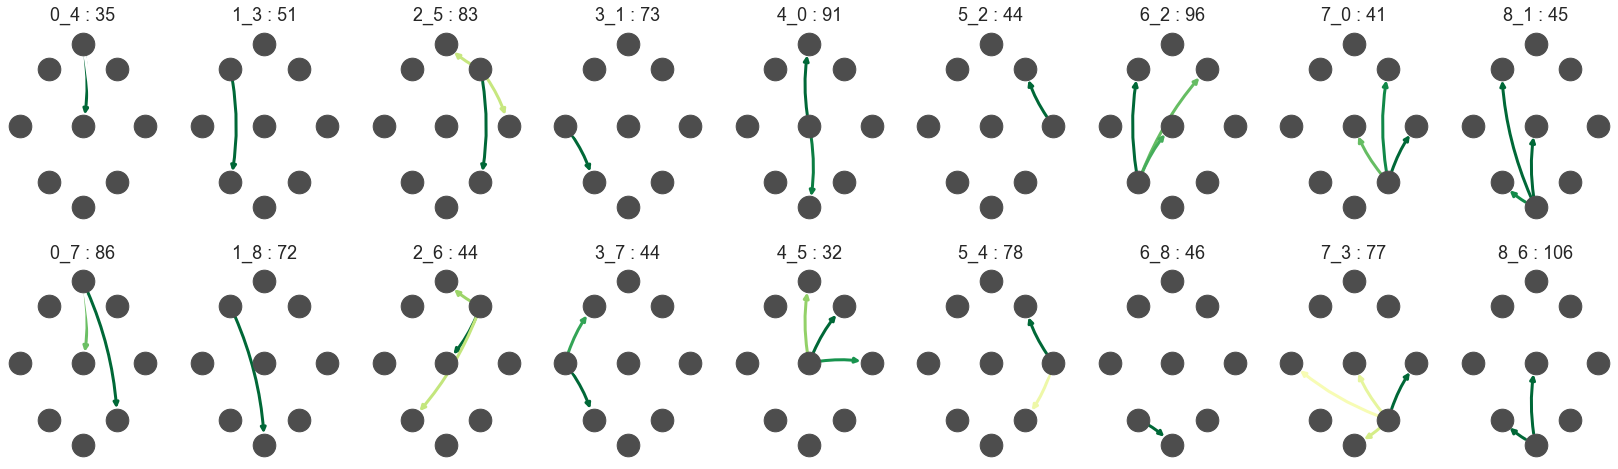

4_3 4_0 1.0 direction
4_3 4_0 1.0 structure
7_0 7_2 0.5443037974683544 direction
Direction mistakes: 2 
Structure mistakes: 1 
Recently added mistakes: 0 
Shorter sequence: ['8_1', '1_8', '1_6', '6_1', '6_3', '3_6', '3_4', '4_3', '4_0', '0_4', '0_7', '7_0']
line : [8, 1, 6, 3, 4, 0, 7, 2, 5] 
number of sessions: 52 
C00494062_1


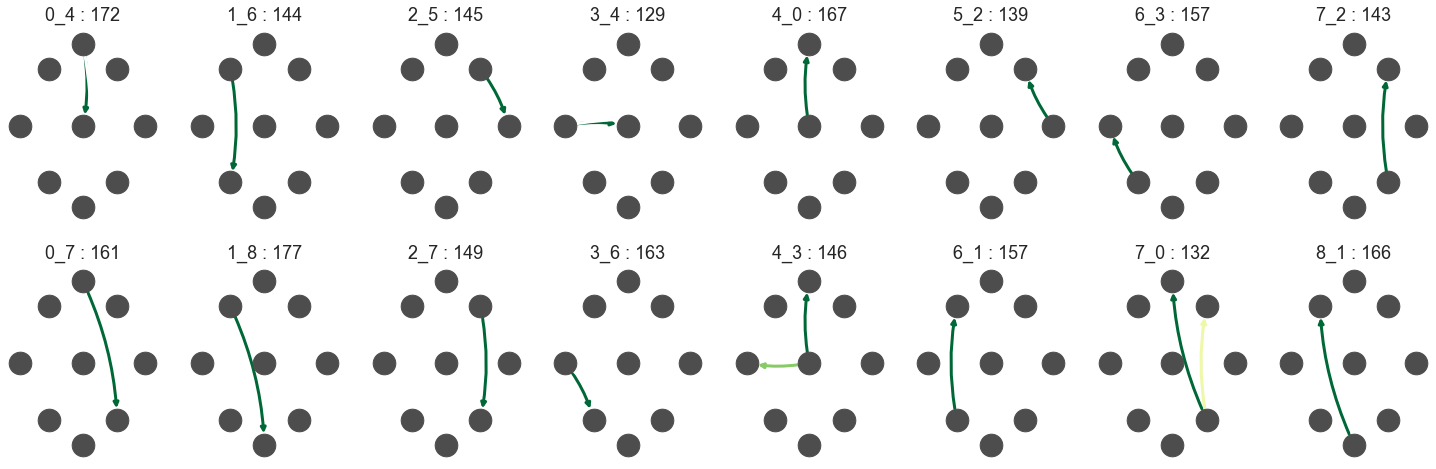

2_3 2_8 0.991869918699187 direction
2_3 2_8 0.991869918699187 recent_add
3_2 3_4 0.5407407407407407 structure
3_2 3_4 0.5407407407407407 recent_add
3_2 3_6 1.0 direction
3_2 3_6 1.0 structure
3_2 3_6 1.0 recent_add
4_5 4_0 1.0 direction
4_5 4_0 1.0 structure
7_1 7_5 1.0 direction
Direction mistakes: 4 
Structure mistakes: 3 
Recently added mistakes: 3 
Shorter sequence: ['0_4', '4_0', '4_5', '5_4', '5_7', '7_5', '7_1', '1_7', '1_8', '8_1', '8_2', '2_8']
line : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 144 
C00494062_1


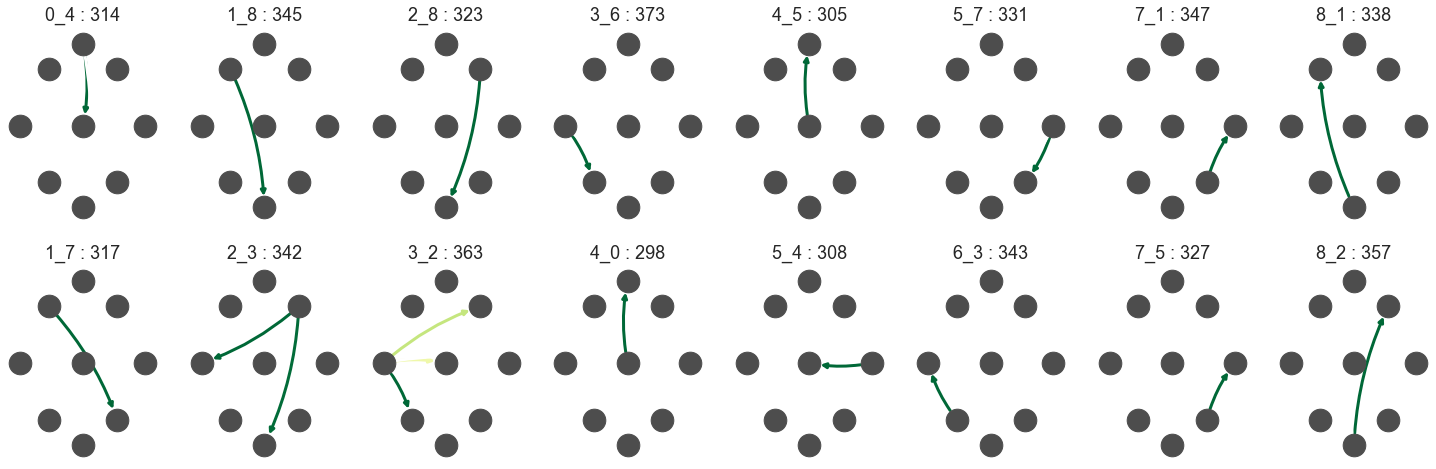

4_3 4_0 0.5 direction
4_3 4_0 0.5 structure
7_0 7_2 0.8476190476190476 direction
Direction mistakes: 2 
Structure mistakes: 1 
Recently added mistakes: 0 
Shorter sequence: ['8_1', '1_8', '1_6', '6_1', '6_3', '3_6', '3_4', '4_3', '4_0', '0_4', '0_7', '7_0']
line : [8, 1, 6, 3, 4, 0, 7, 2, 5] 
number of sessions: 56 
C00494062_4


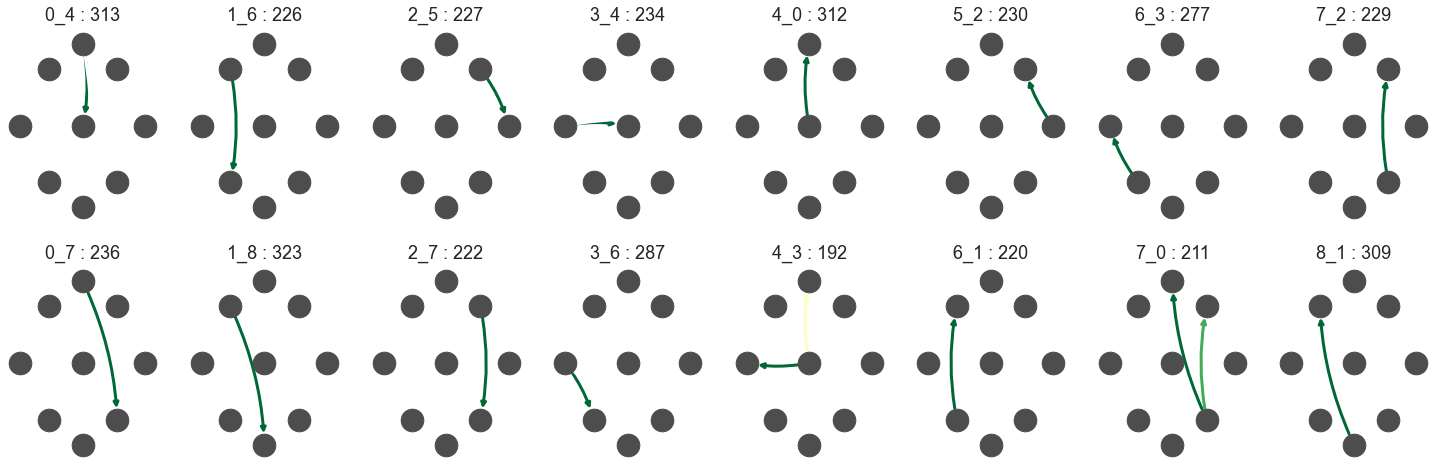

0_6 0_4 0.7808219178082192 direction
0_6 0_4 0.7808219178082192 structure
0_6 0_4 0.7808219178082192 recent_add
2_3 2_5 0.5 structure
2_3 2_5 0.5 recent_add
2_3 2_8 1.0 direction
2_3 2_8 1.0 recent_add
3_2 3_6 1.0 direction
3_2 3_6 1.0 structure
3_2 3_6 1.0 recent_add
4_5 4_0 1.0 direction
4_5 4_0 1.0 structure
6_0 6_1 1.0 structure
6_0 6_1 1.0 recent_add
7_1 7_0 0.9705882352941176 structure
Direction mistakes: 4 
Structure mistakes: 6 
Recently added mistakes: 5 
Shorter sequence: ['0_4', '4_5', '5_7', '7_1', '1_8', '8_2', '2_0', '2_8', '8_1', '1_7', '7_5', '5_4', '4_0', '0_2']
loop : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 88 
C00494062_4


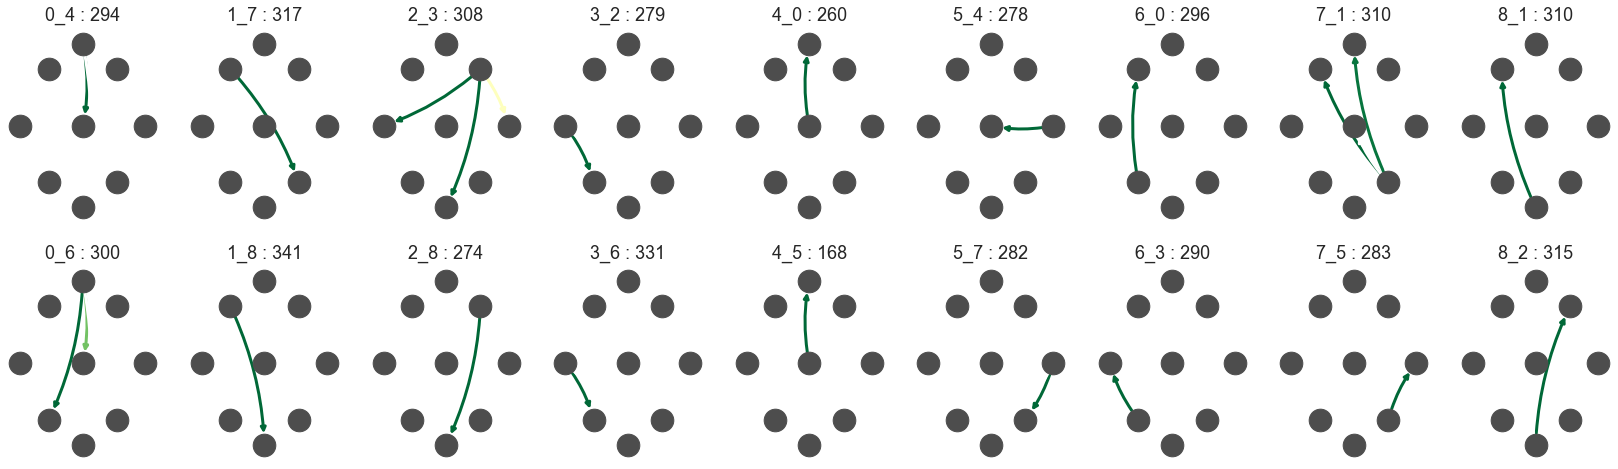

1_5 1_0 1.0 structure
1_5 1_0 1.0 recent_add
1_5 1_8 0.7272727272727273 structure
1_5 1_8 0.7272727272727273 recent_add
1_7 1_4 0.5 recent_add
1_7 1_8 1.0 structure
1_7 1_8 1.0 recent_add
5_1 5_2 0.7857142857142857 structure
5_1 5_2 0.7857142857142857 recent_add
5_1 5_7 1.0 structure
5_1 5_7 1.0 recent_add
Direction mistakes: 0 
Structure mistakes: 5 
Recently added mistakes: 6 
Shorter sequence: ['0_2', '2_0', '2_4', '4_2', '4_3', '3_4', '3_6', '6_3', '6_8', '8_6', '8_7', '7_8']
line : [0, 2, 4, 3, 6, 8, 7, 1, 5] 
number of sessions: 18 
C00499495_4


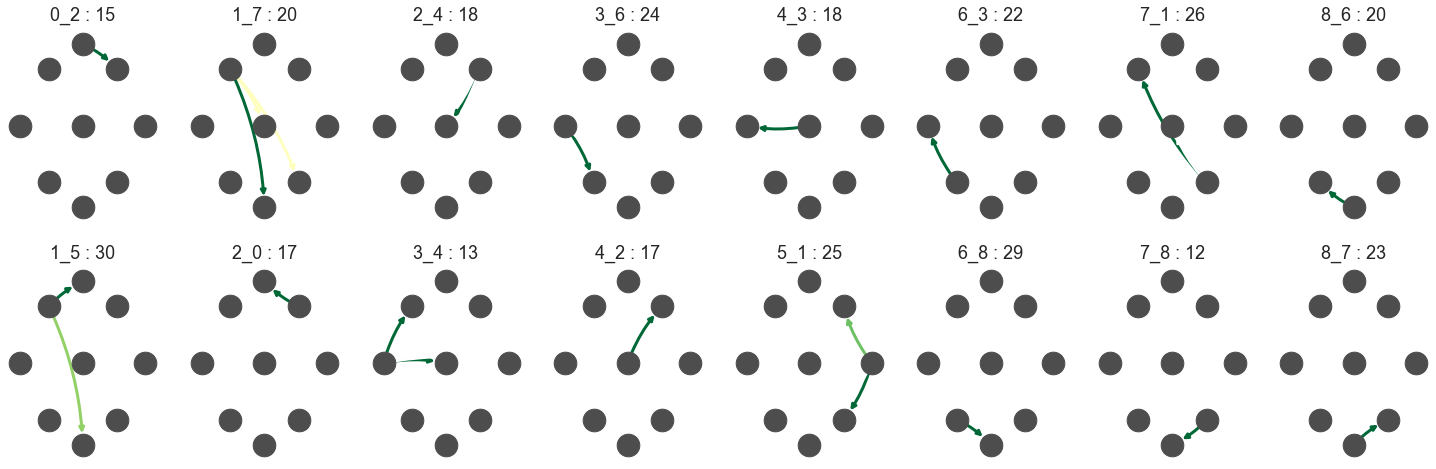

0_1 0_4 0.6707317073170732 direction
2_3 2_0 0.9767441860465116 structure
2_3 2_0 0.9767441860465116 recent_add
2_3 2_1 0.6046511627906976 recent_add
2_3 2_4 0.5348837209302325 structure
2_3 2_4 0.5348837209302325 recent_add
2_3 2_5 1.0 direction
2_3 2_5 1.0 recent_add
2_5 2_0 0.5308641975308642 structure
2_5 2_0 0.5308641975308642 recent_add
3_2 3_1 1.0 recent_add
3_2 3_4 0.65 structure
3_2 3_4 0.65 recent_add
8_1 8_7 1.0 structure
Direction mistakes: 2 
Structure mistakes: 5 
Recently added mistakes: 7 
Shorter sequence: ['6_8', '8_1', '1_0', '0_4', '4_7', '7_5', '5_6', '5_7', '7_4', '4_0', '0_1', '1_8', '8_6', '6_5']
loop : [6, 8, 1, 0, 4, 7, 5, 2, 3] 
number of sessions: 150 
C00499495_4


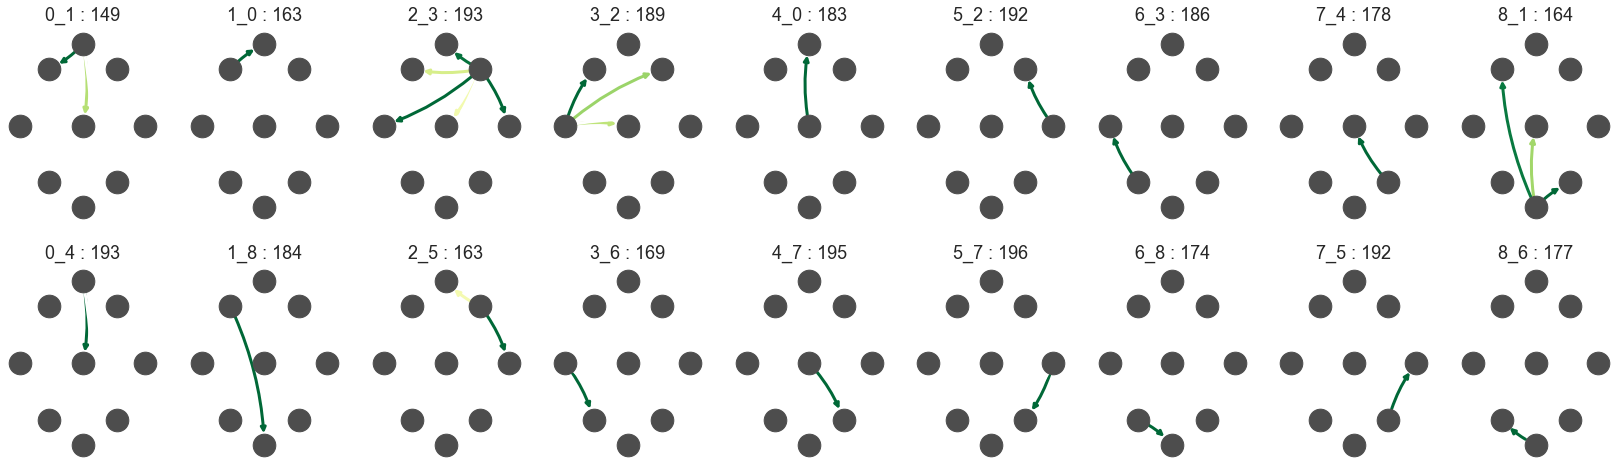

1_3 1_6 1.0 direction
1_3 1_6 1.0 recent_add
2_5 2_0 0.5 structure
4_2 4_8 0.7045454545454546 direction
4_2 4_8 0.7045454545454546 structure
5_2 5_7 0.9777777777777777 direction
5_2 5_7 0.9777777777777777 structure
7_0 7_5 1.0 direction
7_0 7_5 1.0 structure
Direction mistakes: 4 
Structure mistakes: 4 
Recently added mistakes: 1 
Shorter sequence: ['8_4', '4_8', '4_2', '2_4', '2_5', '5_2', '5_7', '7_5', '7_0', '0_7', '0_6', '6_0']
line : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 44 
C00494062_5


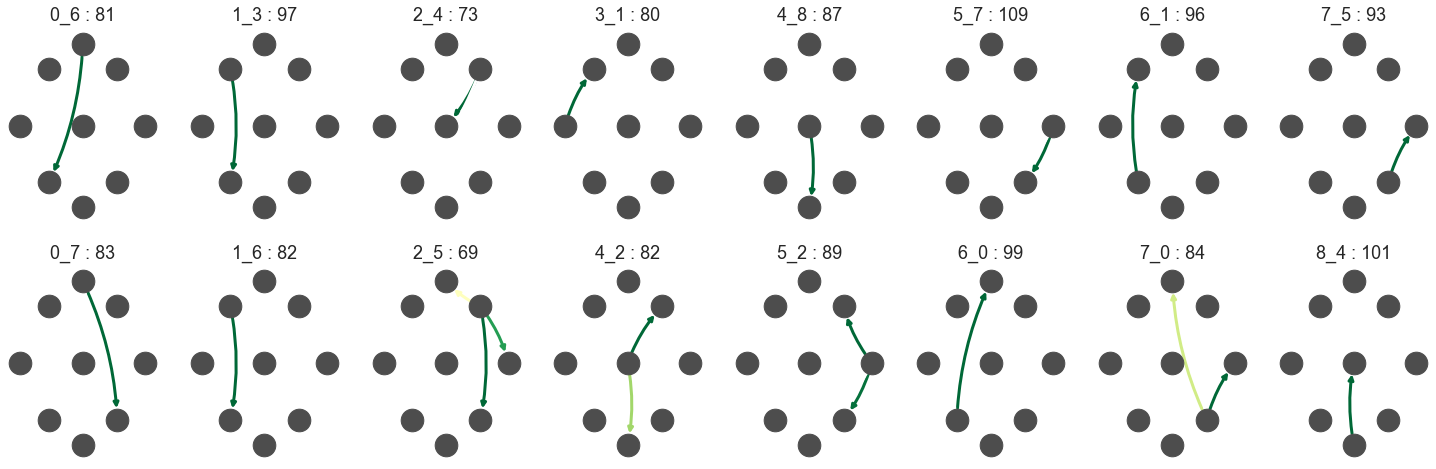

0_2 0_7 1.0 structure
1_3 1_6 0.8169014084507042 structure
6_3 6_1 0.5588235294117647 structure
8_2 8_4 1.0 direction
8_2 8_4 1.0 structure
Direction mistakes: 1 
Structure mistakes: 4 
Recently added mistakes: 0 
Shorter sequence: ['1_3', '3_1', '3_6', '6_3', '6_0', '0_6', '0_2', '2_0', '2_8', '8_2', '8_4', '4_8']
line : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 84 
C00494062_5


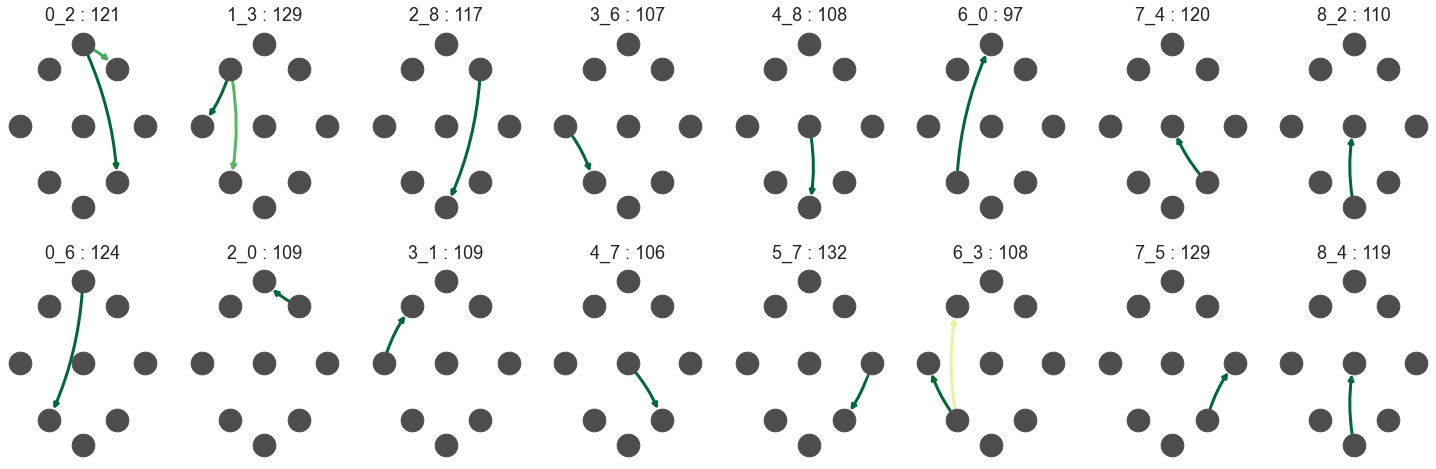

CPU times: user 2min 8s, sys: 1.59 s, total: 2min 10s
Wall time: 2min 11s


In [29]:
%%time
subjects = df['subject'].unique()

sessions_arr = [[0,-1]]
subjects = df['subject'].unique()

directt = np.empty((len(subjects),len(sessions_arr),2))
structt = np.empty((len(subjects),len(sessions_arr),2))
rec_addd = np.empty((len(subjects),len(sessions_arr),2))
numbers_r = np.empty((len(subjects),len(sessions_arr),2))
mist_counterr = np.empty((len(subjects),len(sessions_arr),2))
to_88 = np.empty((len(subjects),len(sessions_arr),2))

directt[:]=np.nan
structt[:]=np.nan
rec_addd[:]=np.nan
numbers_r[:]=np.nan
mist_counterr[:]=np.nan
to_88[:]=np.nan

for indxx,subject in enumerate(subjects):
    for indx,session_lim in enumerate(sessions_arr):
        for i in [0,1]:
            direct,struct,rec_add,mist_counter,to_8 = show_mistakes(subject,task_nr=i,min_rew=20,r_len_seq=9,
                                  less_than_p=0.5,reorder=True,n_days=120,show_raw=True,sessions_arr=session_lim)
            directt[indxx,indx,i]=direct
            structt[indxx,indx,i]=struct
            rec_addd[indxx,indx,i]=rec_add
            mist_counterr[indxx,indx,i]=mist_counter
            numbers_r[indxx,indx,i]=session_lim[0]
            to_88[indxx,indx,i]=to_8

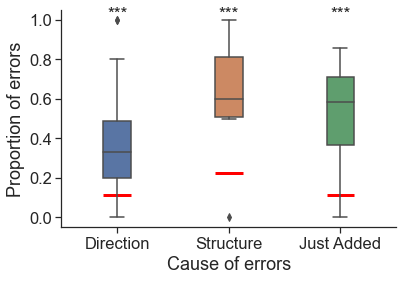

In [42]:

n=9
total_trans = (n*(n-1))

expected = (8/total_trans,16/total_trans,1/n)
y = np.hstack(np.vstack(mist_counterr[:-1]))

a =  np.hstack(np.vstack(directt[:-1]/mist_counterr[:-1]))
b =  np.hstack(np.vstack(structt[:-1]/mist_counterr[:-1]))
c =  np.hstack(np.vstack(rec_addd[:-1]/mist_counterr[:-1]))

aa = a
bb = b
cc = c

labels = ["Direction","Structure", "Just Added"]
x = [a, b, c]
ax = sns.boxplot(data = x,width=0.25)
#ax = sns.swarmplot(data = x, color = 'black',alpha=0.5)

#ax = sns.violinplot(data = x, inner ='box' , width = 0.5)
ax.set_xticklabels(labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#p = sns.stripplot(x="Error Type", y="asd", data=x, size=4, color=".7", zorder=1)
# _ = [ax.hlines(y, i-.2, i+.2, zorder=2,color='black') for i, y in zip((0,1,2),np.median(x,axis=1))]
_ = [ax.hlines(y, i-.125, i+.125, zorder=2,color='red',linewidths=3) for i, y in zip((0,1,2),expected)]

plt.text(0,1*1.005,s='***',ha='center',size='xx-large')
plt.text(1,1*1.005,s='***',ha='center',size='xx-large')
plt.text(2,1*1.005,s='***',ha='center',size='xx-large')
ax.set_xlabel('Cause of errors')
ax.set_ylabel('Proportion of errors')
save_figure('Cause of errors')

In [31]:
n = sum(np.hstack(np.vstack(mist_counterr[:-1])))
k = sum(np.hstack(np.vstack(rec_addd[:-1])))

stt.binom_test(k, n, p=expected[2], alternative='two-sided')

4.626975299546544e-34

In [1063]:
sessions_arr

[[0, -1]]

In [1079]:
# dup_d=directt
# dup_s=structt
# dup_r=rec_addd
# dup_m=mist_counterr
# dup_n=numbers_r


y = np.hstack(np.vstack(mist_counterr[:-1]))
x = np.hstack(np.vstack(numbers_r[:-1]))


a = y[np.where(x==sessions_arr[0][0])[0]]
b = y[np.where(x==sessions_arr[1][0])[0]]


if stt.ttest_rel(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.1
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.005,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")
    
labels = ["Early","Late"]
x = [a, b]
#ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = 'box' , width = 0.5)
ax.set_xticklabels(labels)


IndexError: list index out of range

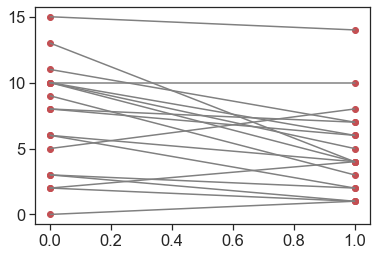

In [549]:
befores = a
afters = b

plt.scatter(np.zeros(len(befores)), befores, c='r')
plt.scatter(np.ones(len(afters)), afters,c='r')

# plotting the lines
for i in range(len(befores)):
    plt.plot( [0,1], [befores[i], afters[i]], c='grey')


## Logistic regression classifier:
Things that influence the transition made:
- Target transition
    - Whether a transition is the target transition should be the main influence
- Recency that the transition was added
    - The number of rewards since the transition was added
- Distance
    - Distance between a given port and the first port in the target transition
    - Distance between a given port and the second port in the target transition
- Structure confusion
    - If a given transition (that starts on at the first port in the target transition is in the other structure) it is more likely
- Direction confusion
    - The transition in the opposite direction will have increased likelihood
- Cumulative number of training sessions w > x number rewards
    - More training -> increased likelihood of target transition being performed

So target is to:
- y = probe_to
- X = (probe_from, probe_target, alt structure options, alt direction option, number of rewards since trans was added)



# Need to give information that is agnostic to port number:

- distance from-to
- distance of alt structure to target + from
- distance of alt direction to target + from
- do alt dir + alt str match
- angle between these

- we dont need to know the importance of the target because that is just indicated by #correct?

add angle with a maximum of 180 degrees
add L2 regularisation - where u are assuming the variables are coming form a normal distribution
plot across animals
cell 74 (1 peak), cell 58 (multiple peaks), and 1 

In [29]:
#repeat for individual subjects:

In [30]:
subjects = df['subject'].unique()


In [107]:
#Calc dist between relevant ports
def dist_btwn_2ports(port1, port2):
    poke_pos = np.array([1,-1])*np.array([ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]])
    
    
    distance = ((poke_pos[port1][:,0] - poke_pos[port2][:,0])**2 +
            (poke_pos[port1][:,1] - poke_pos[port2][:,1])**2)**(1/2)
    poke_pos=poke_pos[0:9]
    return distance

#calculating angle between 3 ports
def angle_btwn_3ports(portI,portMid,portII):
    ang_array = np.zeros(len(portI))
    ang_array[:]='NaN'
    
    for i in np.arange(len(portI)):

        point1 = poke_pos[portI[i]]
        middle = poke_pos[portMid[i]]
        point2 = poke_pos[portII[i]]

        if portI[i] == portII[i]:
            angle = 0
        else:
            vector_1 = point1-middle
            vector_2 = point2-middle

            unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
            unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
            dot_product = np.dot(unit_vector_1, unit_vector_2)
            angle = np.arccos(dot_product)

        ang_array[i] = angle
    
    return ang_array

In [116]:
def jk_regression(subject_name,task_nr):
    #bit shit, but only do thianalysis for loops
    min_rew = 20
    r_len_seq = 9
    graph_type = df[(df['n_rewards']>min_rew)\
                                            & (df['subject']==subject_name)\
                                            & (df['task_nr']==task_nr)\
                                            & (df['len_seq']==r_len_seq)\
                                            & (df['probe_dict']!={})]['graph_type'].values[0]
    alt_graph_type = df[(df['n_rewards']>min_rew)\
                                                & (df['subject']==subject_name)\
                                                & (df['task_nr']==abs(task_nr-1))\
                                                & (df['len_seq']==r_len_seq)\
                                                & (df['probe_dict']!={})]['graph_type'].values[0]
    line_ctr = 0
    if (graph_type == 'loop') & (alt_graph_type == 'loop'):
        
        

        df1 = df[(df['n_rewards']>min_rew)\
                & (df['subject']==subject_name)\
                & (df['task_nr']==task_nr)\
                & (df['len_seq']==r_len_seq)\
                & (df['probe_dict']!={})]

        probe_to = np.concatenate(df1['probe_to'].values)
        probe_from = np.concatenate(df1['probe_from'].values)
        probe_target = np.concatenate(df1['probe_target'].values)

        num_rewards = []
        rew_min = 0

    #     for i in np.arange(len(df1['probe_target'])):
    #         rew_max = rew_min + df1['n_rewards'].values[i]
    #         rew_value = df1['n_rewards']
    #         num_rewards.append(np.linspace(rew_min, rew_max, len(df1['probe_target'].values[i])))
    #         rew_min = rew_max

    #     num_rewards = np.concatenate(num_rewards)

    #     rew_per_step=[]
    #     for i in np.arange(r_len_seq):
    #         rew_per_step.append(sum(df[(df['n_rewards']>min_rew)\
    #             & (df['subject']==subject_name)\
    #             & (df['task_nr']==task_nr)\
    #             & (df['len_seq']==r_len_seq-(r_len_seq-i))\
    #             & (df['probe_dict']!={})]['n_rewards'].values))


    #     ii = 4
    #     order_added = []
    #     x = []
    #     y = []
    #     if df[(df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)]\
    #         ['graph_type'].values[-1]=='loop': lengths = [4,5,6,7,9]
    #     elif df[(df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)]\
    #         ['graph_type'].values[-1]=='line': lengths = [4,5,6,7,8,9]


    # #     for i in lengths:
    #         x = df[(df['n_rewards']>min_rew)\
    #                 & (df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)\
    #                 & (df['len_seq']==i)\
    #                 & (df['probe_dict']!={})]['seq'].values[0]

    #         y = df[(df['n_rewards']>min_rew)\
    #                 & (df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)\
    #                 & (df['len_seq']==ii)\
    #                 & (df['probe_dict']!={})]['seq'].values[0]
    #         order_added.append(list(set(x).symmetric_difference(set(y))))
    #         ii = i
    #     order_added = np.concatenate(order_added).astype(int)
    #     order_added = np.concatenate((x[:4],order_added))

    #     #might need to make this probe_target instead of probe_from, depends on how theyre added
    #     for index,i in enumerate(probe_from):
    #         if (i==order_added[0])|(i==order_added[1])|(i==order_added[2])|(i==order_added[3]):
    #             num_rewards[index]=num_rewards[index]+sum(rew_per_step)
    #         elif i == order_added[4]:
    #             num_rewards[index]=num_rewards[index]+sum(rew_per_step[4:])
    #         elif i == order_added[5]:
    #             num_rewards[index]=num_rewards[index]+sum(rew_per_step[5:])
    #         elif i == order_added[6]:
    #             num_rewards[index]=num_rewards[index]+sum(rew_per_step[6:])
    #         elif df[(df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)]\
    #             ['graph_type'].values[-1]=='line':
    #             if i == order_added[7]:
    #                 num_rewards[index]=num_rewards[index]+sum(rew_per_step[7:])
    #         elif df[(df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)]\
    #             ['graph_type'].values[-1]=='line':
    #             if i == order_added[8]:
    #                 num_rewards[index]=num_rewards[index]
    #         elif df[(df['subject']==subject_name)\
    #                 & (df['task_nr']==task_nr)]\
    #             ['graph_type'].values[-1]=='loop':
    #             if (i==order_added[7])|(i==order_added[8]):
    #                 num_rewards[index]=num_rewards[index]


        probe_alt_direction_arr = []
        probe_alt_str_up_arr = []
        probe_alt_str_down_arr = []

        for probe_from_i, probe_target_i in zip(probe_from,probe_target):

            sequence = df[(df['n_rewards']>min_rew)\
                                                & (df['subject']==subject_name)\
                                                & (df['task_nr']==task_nr)\
                                                & (df['len_seq']==r_len_seq)\
                                                & (df['probe_dict']!={})]['seq'].values[0]
            alt_seq = df[(df['n_rewards']>min_rew)\
                                                & (df['subject']==subject_name)\
                                                & (df['task_nr']==abs(task_nr-1))\
                                                & (df['len_seq']==r_len_seq)\
                                                & (df['probe_dict']!={})]['seq'].values[0]
            graph_type = df[(df['n_rewards']>min_rew)\
                                                & (df['subject']==subject_name)\
                                                & (df['task_nr']==task_nr)\
                                                & (df['len_seq']==r_len_seq)\
                                                & (df['probe_dict']!={})]['graph_type'].values[0]
            alt_graph_type = df[(df['n_rewards']>min_rew)\
                                                & (df['subject']==subject_name)\
                                                & (df['task_nr']==abs(task_nr-1))\
                                                & (df['len_seq']==r_len_seq)\
                                                & (df['probe_dict']!={})]['graph_type'].values[0]
            #alternative direction - how should i deal with the end of lines? gunna do NaN for the time being
            #then remove
            if graph_type == 'line':
                if (probe_from_i==sequence[-1]) or (probe_from_i==sequence[0]): 
                    probe_alt_direction = 'NaN'
                elif sequence[sequence.index(probe_from_i)+1] == probe_target_i:
                    probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
                else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]

            if graph_type == 'loop':
                if (probe_from_i==sequence[-1]):
                    if sequence[sequence.index(probe_from_i)-1] == probe_target_i:
                        probe_alt_direction = sequence[0]
                    else: probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
                elif (probe_from_i==sequence[0]): 
                    if sequence[sequence.index(probe_from_i)+1] == probe_target_i:
                        probe_alt_direction = sequence[-1]
                    else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]
                elif sequence[sequence.index(probe_from_i)+1] == probe_target_i:
                    probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
                else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]

            #alternative structure - im just going to make 2 variables for this, but not sure if thats the most sensible way to do it
            if alt_graph_type == 'line':
                if (probe_from_i==alt_seq[0]):
                    probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
                    probe_alt_str_down = 'NaN'
                elif (probe_from_i==alt_seq[-1]):
                    probe_alt_str_up = 'NaN'
                    probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]
                else:
                    probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
                    probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]

            if alt_graph_type == 'loop':
                if (probe_from_i==alt_seq[0]):
                    probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
                    probe_alt_str_down = alt_seq[-1]
                elif (probe_from_i==alt_seq[-1]): 
                    probe_alt_str_up = alt_seq[0]
                    probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]
                else:
                    probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
                    probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]

            probe_alt_direction_arr.append(probe_alt_direction)
            probe_alt_str_up_arr.append(probe_alt_str_up)
            probe_alt_str_down_arr.append(probe_alt_str_down)

        probe_alt_direction_arr = np.asarray(probe_alt_direction_arr,dtype='int')
        probe_alt_str_up_arr = np.asarray(probe_alt_str_up_arr,dtype='int')
        probe_alt_str_down_arr = np.asarray(probe_alt_str_down_arr,dtype='int')



        dist_from_target = dist_btwn_2ports(probe_from,probe_target)
        dist_target_alt_dir = dist_btwn_2ports(probe_target,probe_alt_direction_arr)
        dist_from_alt_dir = dist_btwn_2ports(probe_from,probe_alt_direction_arr)
        dist_target_alt_str_up = dist_btwn_2ports(probe_target,probe_alt_str_up_arr)
        dist_target_alt_str_down  = dist_btwn_2ports(probe_target,probe_alt_str_down_arr)
        dist_from_alt_str_up = dist_btwn_2ports(probe_from,probe_alt_str_up_arr)
        dist_from_alt_str_down = dist_btwn_2ports(probe_from,probe_alt_str_down_arr)

        #crossover of structure + direction
        alt_dir_str_down_equal = np.asarray(probe_alt_str_down_arr)==np.asarray(probe_alt_direction_arr)

        alt_dir_str_up_equal = np.asarray(probe_alt_str_up_arr)==np.asarray(probe_alt_direction_arr)

        probe_correct = np.asarray(probe_target)==np.asarray(probe_to)


        ang_target_alt_dir = angle_btwn_3ports(probe_target,probe_from,probe_alt_direction_arr)
        ang_target_alt_str_up = angle_btwn_3ports(probe_target,probe_from,probe_alt_str_up_arr)
        ang_target_alt_str_down = angle_btwn_3ports(probe_target,probe_from,probe_alt_str_down_arr)


        X = (dist_from_target,
             dist_target_alt_dir,
             dist_from_alt_dir,
             dist_target_alt_str_up,
             dist_target_alt_str_down,
             dist_from_alt_str_up,
             dist_from_alt_str_down,
             alt_dir_str_down_equal, 
             alt_dir_str_up_equal)
    #          ang_target_alt_dir,
    #          ang_target_alt_str_up,
    #          ang_target_alt_str_down)

        X = np.transpose(X)
        X = X[~np.isnan(X).any(axis=1)] #take out rows where it is  NaN (from end of line)

        y = probe_correct

        #Logistic regression version

        clf = LogisticRegression(max_iter=1000).fit(X[int(0.75*len(X)):], y[int(0.75*len(y)):])
        score = clf.score(X[:int(0.25*len(X))],y[:int(0.25*len(y))])
        coef = clf.coef_
        odds = np.exp(clf.coef_)
        return score,coef,odds,subject_name,X,line_ctr
    else:
        line_ctr=1
        return 'NaN','NaN','NaN','NaN','NaN',line_ctr



In [117]:
#list of coefficient names

x = ('dist_from_to',
         'dist_target_alt_dir',
         'dist_from_alt_dir',
         'dist_target_alt_str_up',
         'dist_target_alt_str_down',
         'dist_from_alt_str_up',
         'dist_from_alt_str_down',
         'alt_dir_str_down_equal',
         'alt_dir_str_up_equal')
#          'ang_target_alt_dir',
#          'ang_target_alt_str_up',
#          'ang_target_alt_str_down')

In [118]:
subject

'C00499495_3'

In [119]:
%%time

names_list = []
scores_list = []
odds_list = []
coef_list = []

for subject in subjects:
    for task_nr in (0,1):
        score,coef,odds,name,X,line_ctr = jk_regression(subject,task_nr)
        names_list.append(name) 
        scores_list.append(score)
        coef_list.append(coef[0])
        odds_list.append(odds[0])

CPU times: user 5min 31s, sys: 880 ms, total: 5min 32s
Wall time: 5min 30s


In [ ]:
for i in np.arange(len(np.vstack(coef_list)[:,0])):
    plt.scatter(x[:], np.vstack(coef_list)[i,:],s=2)

plt.ylabel('Beta')
plt.xlabel('Coefficient name')
plt.tick_params(labelrotation=45)
#plt.yscale('symlog')

In [125]:
#ALL
scores_list

['NaN',
 'NaN',
 'NaN',
 'NaN',
 0.6715425531914894,
 0.7298850574712644,
 'NaN',
 'NaN',
 0.7667560321715817,
 0.7823807026743577,
 0.847682119205298,
 0.6551724137931034,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN']

In [62]:
#Without first  3
scores_list

[0.6715425531914894,
 0.735632183908046,
 0.6552278820375335,
 0.7252228631358154,
 0.7735099337748345,
 0.7]

In [72]:
#Without first 6
scores_list

[0.6143617021276596,
 0.735632183908046,
 0.636461126005362,
 0.6911379129522811,
 0.7827814569536424,
 0.6379310344827587]

In [81]:
#Without first 9
scores_list

[0.5558510638297872,
 0.6551724137931034,
 0.6890080428954424,
 0.6675406397482958,
 0.7827814569536424,
 0.5862068965517241]

In [88]:
#Without final 3 
scores_list

[0.6715425531914894,
 0.7298850574712644,
 0.7667560321715817,
 0.7823807026743577,
 0.847682119205298,
 0.6551724137931034]

In [115]:
tt = X

In [124]:
X

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,  92.59049627,  62.        , ...,  84.17244205,
          0.        ,   0.        ],
       [ 80.45495634, 184.29595763, 234.96808294, ..., 161.38463372,
          0.        ,   0.        ],
       ...,
       [ 83.19855768,  86.        , 132.61221663, ..., 132.61221663,
          1.        ,   0.        ],
       [ 79.61155695, 233.98504226, 184.29595763, ...,  86.        ,
          0.        ,   0.        ],
       [133.22537296,  92.59049627,  62.        , ...,  84.17244205,
          0.        ,   0.        ]])

In [116]:
tt[1,0] = 'NaN'

In [117]:
tt[1,0]

nan

In [119]:
X = X[~np.isnan(X).any(axis=1)]

In [120]:
np.shape(tt)

(1161, 9)

In [121]:
np.shape(X)

(1163, 9)

In [95]:
np.where(np.isnan(X).any(axis=1))

(array([], dtype=int64),)

In [ ]:
X[~np.isnan(x).any(axis=1)]


In [39]:
probe_to = np.concatenate(df1['probe_to'].values)
probe_from = np.concatenate(df1['probe_from'].values)
probe_target = np.concatenate(df1['probe_target'].values)

num_rewards = []
rew_min = 0

for i in np.arange(len(df1['probe_target'])):
    rew_max = rew_min + df1['n_rewards'].values[i]
    rew_value = df1['n_rewards']
    num_rewards.append(np.linspace(rew_min, rew_max, len(df1['probe_target'].values[i])))
    rew_min = rew_max
    
num_rewards = np.concatenate(num_rewards)

NameError: name 'df1' is not defined

In [819]:
ii = 4
order_added = []
x = []
y = []
if df[(df['subject']==subject_name)\
            & (df['task_nr']==task_nr)]\
    ['graph_type'].values[-1]=='loop': lengths = [4,5,6,7,9]
elif df[(df['subject']==subject_name)\
            & (df['task_nr']==task_nr)]\
    ['graph_type'].values[-1]=='line': lengths = [4,5,6,7,8,9]


for i in lengths:
    x = df[(df['n_rewards']>min_rew)\
            & (df['subject']==subject_name)\
            & (df['task_nr']==task_nr)\
            & (df['len_seq']==i)\
            & (df['probe_dict']!={})]['seq'].values[0]

    y = df[(df['n_rewards']>min_rew)\
            & (df['subject']==subject_name)\
            & (df['task_nr']==task_nr)\
            & (df['len_seq']==ii)\
            & (df['probe_dict']!={})]['seq'].values[0]
    order_added.append(list(set(x).symmetric_difference(set(y))))
    ii = i
order_added = np.concatenate(order_added).astype(int)
order_added = np.concatenate((x[:4],order_added))

In [820]:
#might need to make this probe_target instead of probe_from, depends on how theyre added
for index,i in enumerate(probe_from):
    if (i==order_added[0])|(i==order_added[1])|(i==order_added[2])|(i==order_added[3]):
        num_rewards[index]=num_rewards[index]+sum(rew_per_step)
    elif i == order_added[4]:
        num_rewards[index]=num_rewards[index]+sum(rew_per_step[4:])
    elif i == order_added[5]:
        num_rewards[index]=num_rewards[index]+sum(rew_per_step[5:])
    elif i == order_added[6]:
        num_rewards[index]=num_rewards[index]+sum(rew_per_step[6:])
    elif df[(df['subject']==subject_name)\
            & (df['task_nr']==task_nr)]\
        ['graph_type'].values[-1]=='line':
        if i == order_added[7]:
            num_rewards[index]=num_rewards[index]+sum(rew_per_step[7:])
    elif df[(df['subject']==subject_name)\
            & (df['task_nr']==task_nr)]\
        ['graph_type'].values[-1]=='line':
        if i == order_added[8]:
            num_rewards[index]=num_rewards[index]
    elif df[(df['subject']==subject_name)\
            & (df['task_nr']==task_nr)]\
        ['graph_type'].values[-1]=='loop':
        if (i==order_added[7])|(i==order_added[8]):
            num_rewards[index]=num_rewards[index]

In [38]:
probe_alt_direction_arr = []
probe_alt_str_up_arr = []
probe_alt_str_down_arr = []

for probe_from_i, probe_target_i in zip(probe_from,probe_target):

    sequence = df[(df['n_rewards']>min_rew)\
                                        & (df['subject']==subject_name)\
                                        & (df['task_nr']==task_nr)\
                                        & (df['len_seq']==r_len_seq)\
                                        & (df['probe_dict']!={})]['seq'].values[0]
    alt_seq = df[(df['n_rewards']>min_rew)\
                                        & (df['subject']==subject_name)\
                                        & (df['task_nr']==abs(task_nr-1))\
                                        & (df['len_seq']==r_len_seq)\
                                        & (df['probe_dict']!={})]['seq'].values[0]
    graph_type = df[(df['n_rewards']>min_rew)\
                                        & (df['subject']==subject_name)\
                                        & (df['task_nr']==task_nr)\
                                        & (df['len_seq']==r_len_seq)\
                                        & (df['probe_dict']!={})]['graph_type'].values[0]
    alt_graph_type = df[(df['n_rewards']>min_rew)\
                                        & (df['subject']==subject_name)\
                                        & (df['task_nr']==abs(task_nr-1))\
                                        & (df['len_seq']==r_len_seq)\
                                        & (df['probe_dict']!={})]['graph_type'].values[0]
    #alternative direction - how should i deal with the end of lines? gunna do NaN for the time being
    if graph_type == 'line':
        if (probe_from_i==sequence[-1]) or (probe_from_i==sequence[0]): 
            probe_alt_direction = 'NaN'
        elif sequence[sequence.index(probe_from_i)+1] == probe_target_i:
            probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
        else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]

    if graph_type == 'loop':
        if (probe_from_i==sequence[-1]):
            if sequence[sequence.index(probe_from_i)-1] == probe_target_i:
                probe_alt_direction = sequence[0]
            else: probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
        elif (probe_from_i==sequence[0]): 
            if sequence[sequence.index(probe_from_i)+1] == probe_target_i:
                probe_alt_direction = sequence[-1]
            else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]
        elif sequence[sequence.index(probe_from_i)+1] == probe_target_i:
            probe_alt_direction = sequence[sequence.index(probe_from_i)-1]
        else: probe_alt_direction = sequence[sequence.index(probe_from_i)+1]

    #alternative structure - im just going to make 2 variables for this, but not sure if thats the most sensible way to do it
    if alt_graph_type == 'line':
        if (probe_from_i==alt_seq[0]):
            probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
            probe_alt_str_down = 'NaN'
        elif (probe_from_i==alt_seq[-1]):
            probe_alt_str_up = 'NaN'
            probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]
        else:
            probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
            probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]

    if alt_graph_type == 'loop':
        if (probe_from_i==alt_seq[0]):
            probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
            probe_alt_str_down = alt_seq[-1]
        elif (probe_from_i==alt_seq[-1]): 
            probe_alt_str_up = alt_seq[0]
            probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]
        else:
            probe_alt_str_up = alt_seq[alt_seq.index(probe_from_i)+1]
            probe_alt_str_down = alt_seq[alt_seq.index(probe_from_i)-1]

    probe_alt_direction_arr.append(probe_alt_direction)
    probe_alt_str_up_arr.append(probe_alt_str_up)
    probe_alt_str_down_arr.append(probe_alt_str_down)
    
probe_alt_direction_arr = np.asarray(probe_alt_direction_arr)
probe_alt_str_up_arr = np.asarray(probe_alt_str_up_arr)
probe_alt_str_down_arr = np.asarray(probe_alt_str_down_arr)

NameError: name 'probe_from' is not defined

In [822]:
def convert2array(variable):
    for i in sequence:
        arr = [0]*len(sequence)
        arr[i]=1
        variable = [arr if x==int(i) else x for x in variable]
    return variable

In [823]:
#Calc dist between relevant ports
def dist_btwn_2ports(port1, port2):
    distance = ((poke_pos[port1][:,0] - poke_pos[port2][:,0])**2 +
            (poke_pos[port1][:,1] - poke_pos[port2][:,1])**2)**(1/2)
    return distance

dist_from_target = dist_btwn_2ports(probe_from,probe_target)
dist_target_alt_dir = dist_btwn_2ports(probe_target,probe_alt_direction_arr)
dist_from_alt_dir = dist_btwn_2ports(probe_from,probe_alt_direction_arr)
dist_target_alt_str_up = dist_btwn_2ports(probe_target,probe_alt_str_up_arr)
dist_target_alt_str_down  = dist_btwn_2ports(probe_target,probe_alt_str_down_arr)
dist_from_alt_str_up = dist_btwn_2ports(probe_from,probe_alt_str_up_arr)
dist_from_alt_str_down = dist_btwn_2ports(probe_from,probe_alt_str_down_arr)

In [824]:
#crossover of structure + direction
alt_dir_str_down_equal = np.asarray(probe_alt_str_down_arr)==np.asarray(probe_alt_direction_arr)

alt_dir_str_up_equal = np.asarray(probe_alt_str_up_arr)==np.asarray(probe_alt_direction_arr)

probe_correct = np.asarray(probe_target)==np.asarray(probe_to)

In [825]:
#calculating angle between 3 points
def angle_btwn_3ports(portI,portMid,portII):
    ang_array = np.zeros(len(portI))
    ang_array[:]='NaN'
    
    for i in np.arange(len(portI)):

        point1 = poke_pos[portI[i]]
        middle = poke_pos[portMid[i]]
        point2 = poke_pos[portII[i]]

        if portI[i] == portII[i]:
            angle = 0
        else:
            vector_1 = point1-middle
            vector_2 = point2-middle

            unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
            unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
            dot_product = np.dot(unit_vector_1, unit_vector_2)
            angle = np.arccos(dot_product)

        ang_array[i] = angle
    
    return ang_array

In [826]:
ang_target_alt_dir = angle_btwn_3ports(probe_target,probe_from,probe_alt_direction_arr)
ang_target_alt_str_up = angle_btwn_3ports(probe_target,probe_from,probe_alt_str_up_arr)
ang_target_alt_str_down = angle_btwn_3ports(probe_target,probe_from,probe_alt_str_down_arr)


In [832]:
X = (dist_target_alt_dir,
     dist_from_alt_dir,
     dist_target_alt_str_up,
     dist_target_alt_str_down,
     dist_from_alt_str_up,
     dist_from_alt_str_down,
     alt_dir_str_down_equal, 
     alt_dir_str_up_equal,
     ang_target_alt_dir,
     ang_target_alt_str_up,
     ang_target_alt_str_down)

X = np.transpose(X)

y = probe_correct

np.shape(X)

(3096, 11)

In [833]:
#Logistic regression version

names_list = []
scores_list = []
odds_list = []

clf = LogisticRegression().fit(X[int(0.75*len(X)):], y[int(0.75*len(y)):])
clf.score(X[:int(0.25*len(X))],y[:int(0.25*len(y))])
odds = np.exp(clf.coef_)


names_list.append(subject_name)
scores_list.append(clf.score(X[:int(0.25*len(X))],y[:int(0.25*len(y))]))
odds_list.append(odds)




/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3_8 3_6 1.0 structure
3_8 3_6 1.0 recent_add
4_2 4_8 1.0 direction
4_2 4_8 1.0 structure
7_0 7_4 1.0 structure
8_3 8_2 0.6 structure
8_3 8_2 0.6 recent_add
8_3 8_4 1.0 direction
8_3 8_4 1.0 structure
8_3 8_4 1.0 recent_add
8_3 8_6 0.6 recent_add
Direction mistakes: 2 
Structure mistakes: 5 
Recently added mistakes: 4 
Shorter sequence: ['8_4', '4_2', '2_5', '5_7', '7_0', '0_6', '6_8', '6_0', '0_7', '7_5', '5_2', '2_4', '4_8', '8_6']
loop : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 32 
C00499495_1


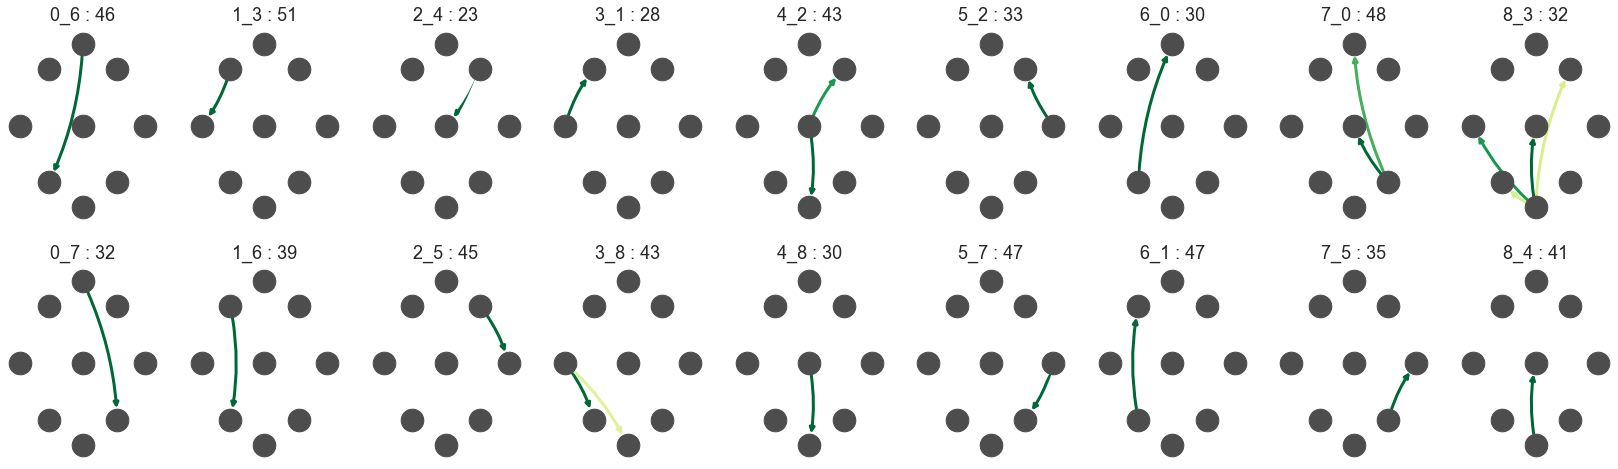

<ipython-input-19-7e5cdc164b81>:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trans_ind = np.where(np.asarray(df.at[session,'probe_transition'])==transition)[0] #get indices of each time it was meant to do this transitiion


1_3 1_6 0.5517241379310345 structure
1_5 1_6 1.0 structure
1_5 1_6 1.0 recent_add
4_7 4_8 1.0 direction
4_7 4_8 1.0 structure
4_7 4_8 1.0 recent_add
5_1 5_2 1.0 structure
5_1 5_2 1.0 recent_add
Direction mistakes: 1 
Structure mistakes: 4 
Recently added mistakes: 3 
Shorter sequence: ['1_3', '3_6', '6_0', '0_2', '2_8', '8_4', '4_1', '4_8', '8_2', '2_0', '0_6', '6_3', '3_1', '1_4']
loop : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 55 
C00499495_1


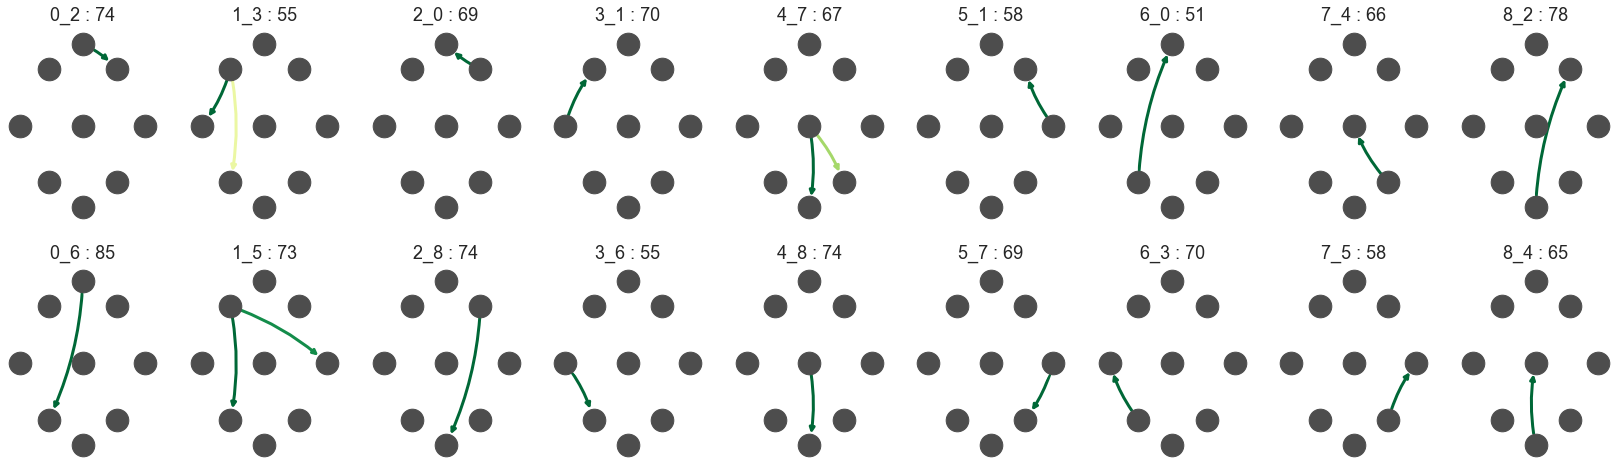

In [128]:
subject = 'C00499495_1'
for i in [0,1]: res_df = show_mistakes(subject,task_nr=i,min_rew=10,r_len_seq=9,
                              less_than_p=0.5,reorder=True,n_days=45,show_raw=True)

